# Análisis exploratorio de los puzzles

Código hecho para ser escalable: información por dataset sin importar añadir o quitar datasets.

El análisis exploratorio de los puzzles se explica en la memoria, aunque aquí se comente y explique el código empleado para hacer este análisis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import numpy as np
from collections import Counter
!pip install chess
import chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 101.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147847 sha256=7115aa58b84c8d6d1d79923b769d91046a0802d469d12106d3eac8182be5d72b
  Stored in directory: /root/.cache/pip/wheels/66/12/21/bbe9160a0aa061440aaa3482bdbf4a91b5690473e63b123e1c
Successfully built chess

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# Aquí importamos los CSV de los puzzles
dfs = {
    'CBP_HARD': pd.read_csv('CBP_HARD_PREVIEW.csv'),
    'SBP_MEDIUM': pd.read_csv('SBP_MEDIUM_FINAL.csv'),
    'SBP_HARD': pd.read_csv('SBP_HARD_FINAL.csv')
}

dfs_Stockfish = {
    'CBP_HARD_Stockfish': pd.read_csv('CBP_HARD_PREVIEW_solved_9M_new.csv'),
    'CBP_HARD_Stockfish_20': pd.read_csv('CBP_HARD_PREVIEW_solved_9M_prof20.csv'),
    'SBP_MEDIUM_Stockfish': pd.read_csv('SBP_MEDIUM_FINAL_solved_9M_new.csv'),
    'SBP_MEDIUM_Stockfish_20': pd.read_csv('SBP_MEDIUM_FINAL_solved_9M_prof20.csv'),
    'SBP_HARD_Stockfish': pd.read_csv('SBP_HARD_solved_9M_new.csv'),
    'SBP_HARD_Stockfish_20': pd.read_csv('SBP_HARD_solved_9M_prof20.csv')
}

## Definición del problema

Los puzzles de ajedrez son una herramienta muy usadas, en un principio para el entrenamiento de jugadores de ajedrez, y ahora para evaluar y entrenar motores. El objetivo del problema es analizar la creatividad del LST para resolver problemas de ajedrez. En particular, con los puzzles se busca, primero, ver cuántos puzzles puede nuestro modelo (y Stockfish, que se usará para comparar soluciones) resolver y, en caso de fallo, evaluar cómo de mala ha sido la jugada alternativa. Esto es, aunque hay una solución por puzzle, generalmente no es la única solución, y las otras jugadas que se pueden hacer en realidad son óptimos locales. Para el análisis, se distinguen dos tipos de puzzles:

- Puzzles de táctica: También llamados de cálculo, se recogen en CBP HARD.csv, se centran en secuencias de jugadas que se deben hacer para resolver el problema. Es decir, solo tiene una única solución, siendo el resto altamente penalizadas. Involucra situaciones como el doble ataque, clavada, jaque mate en N jugadas o ganancias de material, usualmente a vista de 1 a 5 jugadas. Solo se recogen puzzles de dificultad difícil.

- Puzzles de estrategia: Recogidos tanto de dificultad media (en SBP MEDIUM.csv) como de dificultad difícil (SBP HARD.csv), enfatizan en la comprensión posicional a largo plazo. Algunas de las situaciones enfrentadas son la mejora de piezas, el control de casillas clave
o cambios favorables de estructura de peones. A diferencia de los puzzles de táctica, puede tener varias soluciones y la ventaja puede no ser inmediata (a pocas jugadas, como sí ocurría en los de táctica). Dependen menos de un cálculo preciso de variables y más de
un plan general para ganar la partida

En los puzzles de estrategia tenemos una clara división entre problemas de dificultad media y alta. En los de táctica se tienen de dificultad alta. Buscamos evaluar el rendimiento del modelo según la dificultad de la situación enfrentada (en este caso, en ajedrez).

A grandes rasgos, tal y como se expone en el artículo tomado por referencia, el problema es de clasificación. Las probabilidades de que, dado un tablero, el modelo prediga el mejor movimiento, se obtienen de la discretización por K bins.

## Breve descripción de los datasets

Como hemos expuesto anteriormente, se hace una partición de los problemas en varios datasets según dificultad y tipo de problema. Sin embargo, todos se han construido siguiendo un patrón común en cuanto a las columnas que recogen.

- FEN: Estado inicial del tablero para resolver el puzzle. Se usa la notación del mismo nombre que la columna.

- Moves: Columna con la solución al problema. Nótese que es la mejor según el autor de los libros de los que se recogen, pero puede no ser la única solución.

- Moves_UCI: Columna con la solución al problema en formato UCI, notación usada en las predicciones de benchess.

- Puzzle_ID: Cadena de caracteres que identifica de forma única un puzzle de ajedrez.

Puede comprobarse que la dimensionalidad el problema es muy baja (dimensión 4). Por otro lado, se hace un conteo de la cantidad de puzzles por dataset.

In [28]:
conteo_df = pd.DataFrame({
    'Dataset': list(dfs.keys()),
    'Número de puzzles': [df.shape[0] for df in dfs.values()]
})

print(tabulate(conteo_df, headers='keys', tablefmt='fancy_grid'))

╒════╤════════════╤═════════════════════╕
│    │ Dataset    │   Número de puzzles │
╞════╪════════════╪═════════════════════╡
│  0 │ CBP_HARD   │                 209 │
├────┼────────────┼─────────────────────┤
│  1 │ SBP_MEDIUM │                  76 │
├────┼────────────┼─────────────────────┤
│  2 │ SBP_HARD   │                 386 │
╘════╧════════════╧═════════════════════╛


Del conteo podemos extraer:

- Hay una disparidad significativa entre el número de puzzles de los conjuntos, lo que seguramente conlleve a que cada modelo tarde más en resolver un conjunto que otro. El de mayor cantidad es SBP_HARD y el de menos SBP_MEDIUM.

- Se han obtenido más problemas de dificultad difícil (en total 595 de los 671 puzzles en total). Se evalúa de forma muy exhaustiva el comportamiento del modelo con ellos.

A continuación se buscan posibles valores nulos en los datasets. Primero veremos desde un punto de vista global y, si se encuentra alguno, se hará un estudio más a fondo para localizarlo y tratarlo (seguramente con una imputación dada la naturaleza del dato).

In [13]:
nulos_df = pd.DataFrame({
    'Dataset': list(dfs.keys()),
    'Número de valores nulos': [df.isna().sum().sum() for df in dfs.values()]
})

print(tabulate(nulos_df, headers='keys', tablefmt='fancy_grid'))

╒════╤════════════╤═══════════════════════════╕
│    │ Dataset    │   Número de valores nulos │
╞════╪════════════╪═══════════════════════════╡
│  0 │ CBP_HARD   │                         0 │
├────┼────────────┼───────────────────────────┤
│  1 │ SBP_MEDIUM │                         0 │
├────┼────────────┼───────────────────────────┤
│  2 │ SBP_HARD   │                         0 │
╘════╧════════════╧═══════════════════════════╛


In [15]:
nulos_df = dfs['CBP_HARD'].isna().sum().reset_index()
nulos_df.columns = ['Columna','Números de valores nulos']

print(tabulate(nulos_df, headers='keys', tablefmt='fancy_grid'))

╒════╤═══════════╤════════════════════════════╕
│    │ Columna   │   Números de valores nulos │
╞════╪═══════════╪════════════════════════════╡
│  0 │ FEN       │                          0 │
├────┼───────────┼────────────────────────────┤
│  1 │ Moves     │                          0 │
├────┼───────────┼────────────────────────────┤
│  2 │ Moves_UCI │                          0 │
├────┼───────────┼────────────────────────────┤
│  3 │ Puzzle_ID │                          0 │
╘════╧═══════════╧════════════════════════════╛


## Distribuciones estadísticas

Distribución de longitud del FEN

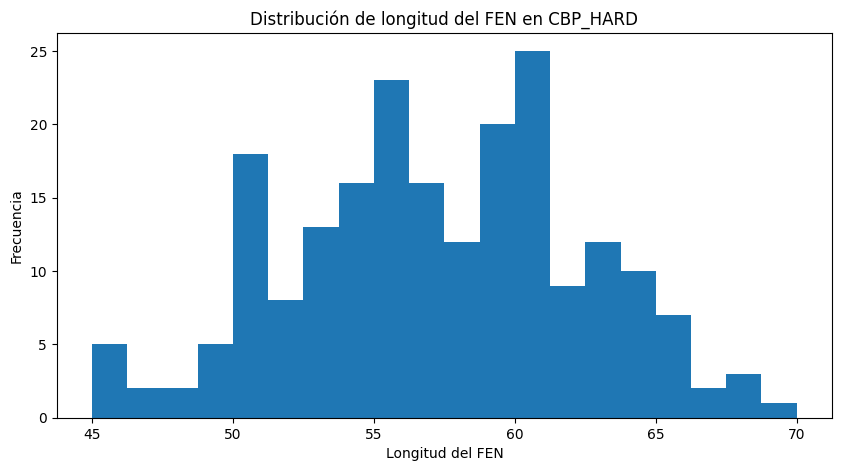

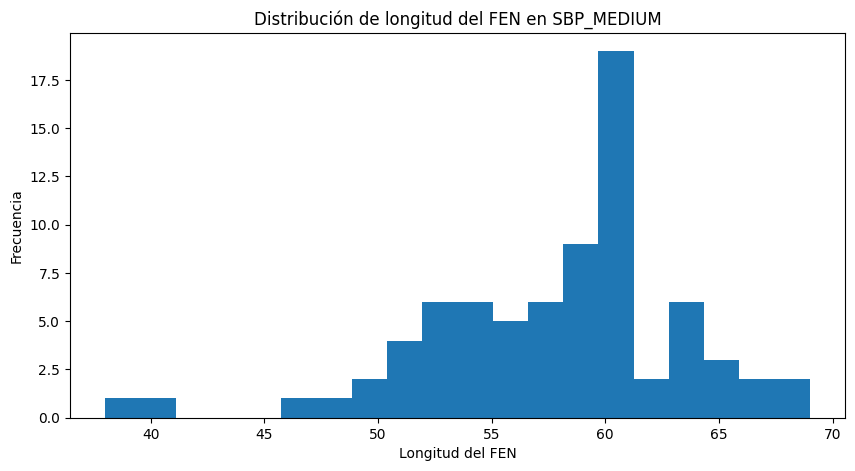

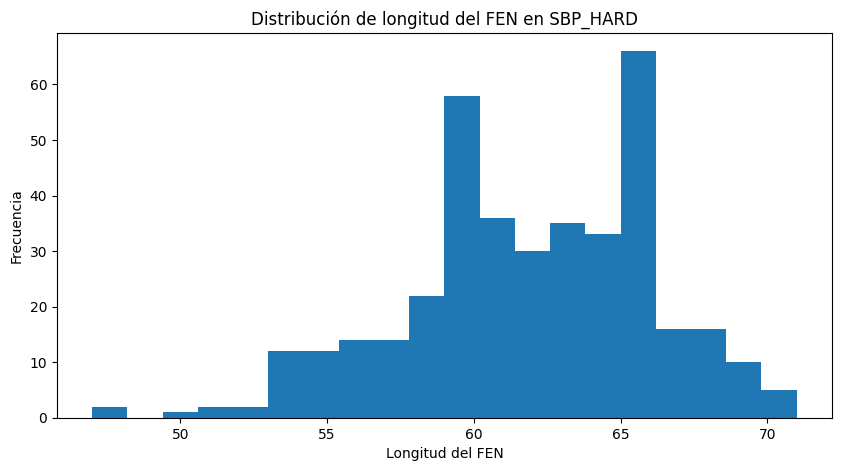

In [17]:
for name,df in dfs.items():
    longitud_fen = df['FEN'].str.len()
    plt.figure(figsize=(10, 5))
    plt.hist(longitud_fen,bins=20)
    plt.title(f'Distribución de longitud del FEN en {name}')
    plt.xlabel('Longitud del FEN')
    plt.ylabel('Frecuencia')
    plt.show()

En general los FEN en los puzzles de táctica suelen ser más cortos, o los de estrategia más largos.

Distribución del tipo de pieza que empieza la solución

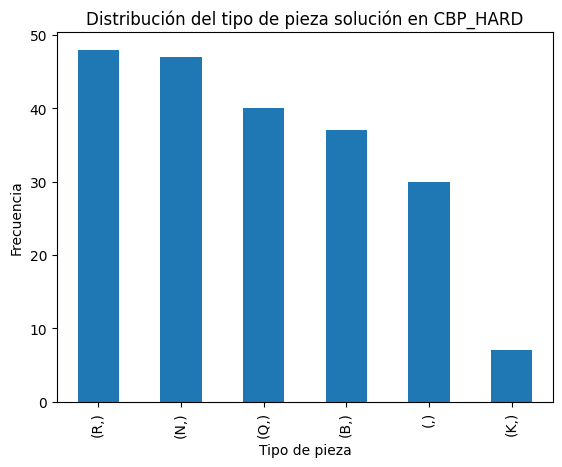

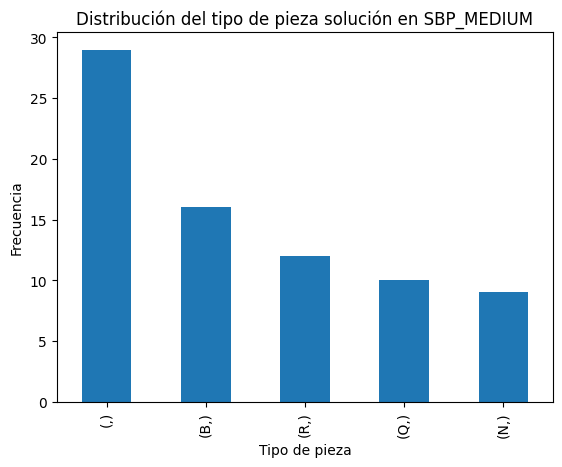

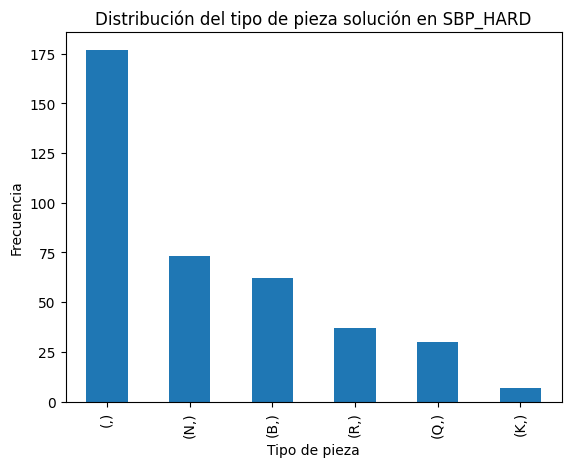

In [34]:
for name,df in dfs.items():
    initial = df['Moves'].str.extract(r'^([KQRBN]?)')
    initial.value_counts().plot(kind='bar',title=f'Distribución del tipo de pieza solución en {name}')
    plt.xlabel('Tipo de pieza')
    plt.ylabel('Frecuencia')
    plt.show()

Ahora vamos a ver la distribución de piezas que son la solución al problema por dataset. Por ejemplo, si la solución es mover un peón, la dama,... y se muestra por dataset.

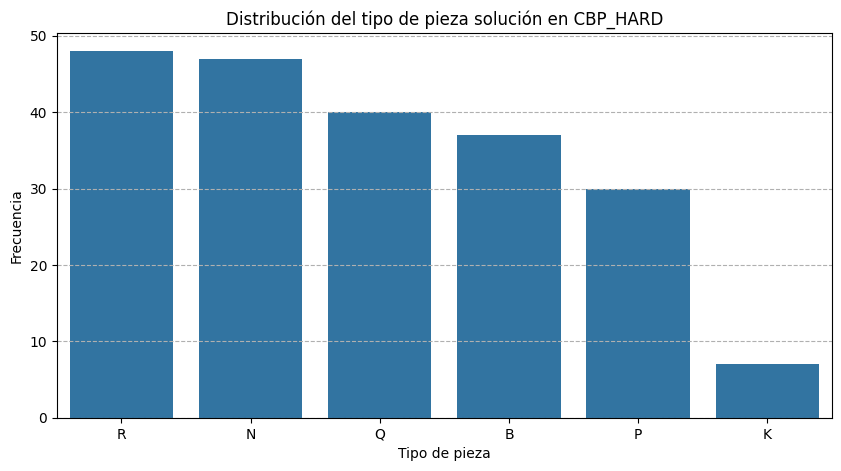

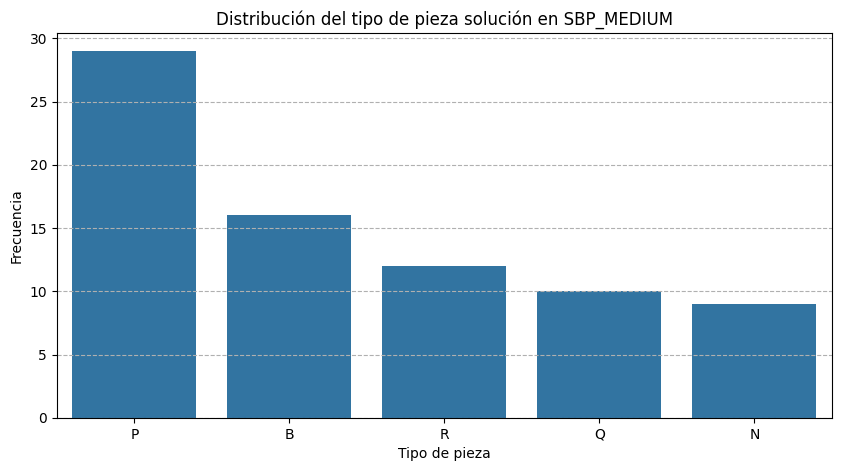

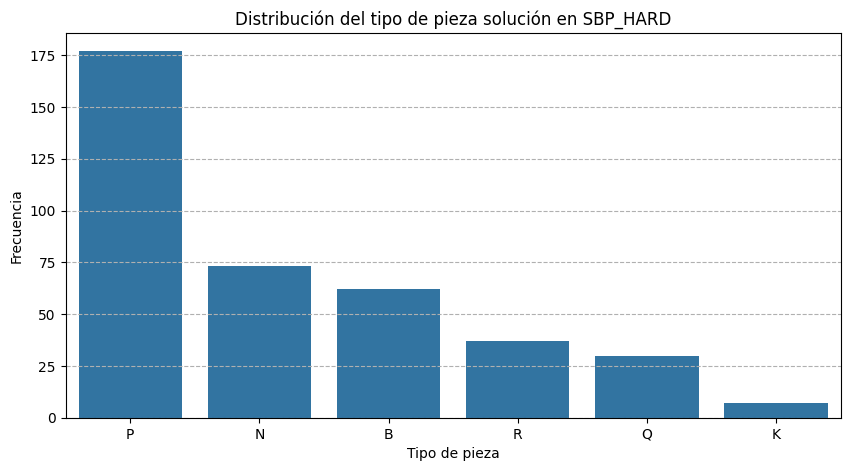

In [10]:
# Distribución de piezas que son solución al problema por dataset mediante un histograma

def pieza_que_gana(fen, move):
    if pd.isna(move):
        return "Desconocida"
    board = chess.Board(fen)
    move_obj = chess.Move.from_uci(move)
    piece = board.piece_at(move_obj.from_square)
    return piece.symbol().upper() if piece else "Desconocida"

# Generar histograma para cada dataset
for name, df in dfs.items():
    df['Pieza solución'] = df.apply(lambda x: pieza_que_gana(x['FEN'], x['Moves_UCI']), axis=1)
    
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x='Pieza solución', order=df['Pieza solución'].value_counts().index)
    plt.title(f'Distribución del tipo de pieza solución en {name}')
    plt.ylabel('Frecuencia')
    plt.xlabel('Tipo de pieza')
    plt.grid(axis='y', linestyle='--')
    plt.show()

Extraemos las siguientes conclusiones:

- En los puzzles de estrategia difícil, la mayoría de soluciones corresponden a peones (sin notación), seguidos como los caballos y alfiles. Esto da a entender que en situaciones estratégicas complejas, los avances de peones juegan un papel importante en mejoría de posiciones, lo que es típico en problemas donde se busca una mejor posición a largo plazo.

- En los puzzles de táctica difícil se presenta una distribución más equilibrada. Hay algunas piezas que se juegan algo más que otras, como las torres, caballos y reinas. Esto se desprende de la naturaliza táctica donde los sacrificos, las combinaciones y los ataques son más frecuentes y, por tanto, se debe tener una mayor capacidad ofensiva.

- En los puzzles de estrategia de nivel medio también predomina el peón como solución, aunque en menor proporción que en los de estrategia difícil. El resto de piezas se distribuyen de forma algo más equilibrada.

Procedemos con un estudio de la distribución del total de piezas. En el eje X el total de piezas y en el Y en número de puzzles en que eso ocurre.

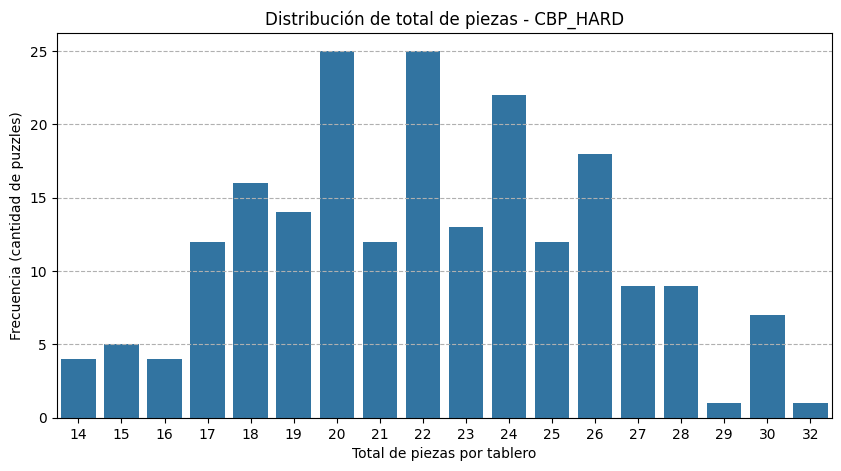

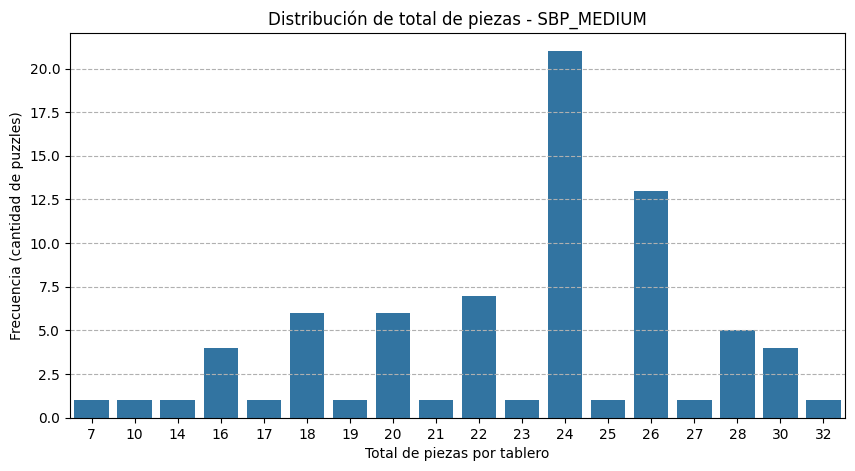

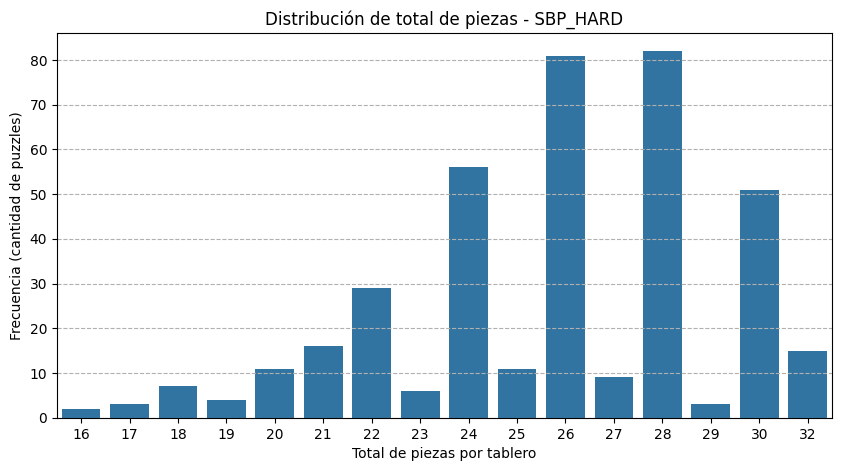

In [13]:
def count_pieces(fen):
    board = chess.Board(fen)
    return len([sq for sq in chess.SQUARES if board.piece_at(sq)])

for name,df in dfs.items():
    df['TotalPiezas'] = df['FEN'].apply(count_pieces)

    plt.figure(figsize=(10,5))
    sns.countplot(data=df,x='TotalPiezas', order=sorted(df['TotalPiezas'].value_counts().index))
    plt.title(f'Distribución de total de piezas - {name}')
    plt.xlabel('Total de piezas por tablero')
    plt.ylabel('Frecuencia (cantidad de puzzles)')
    plt.grid(axis='y', linestyle='--')
    plt.show()

- En los puzzles de táctica difícil, la mayoría de tableros tienen entre 20 y 26 piezas, con un pico importante en 20 y 22 piezas. De aqu´ı podemos ver que en los puzzles tácticos se tiende a proponer posiciones con muchas piezas activas, por lo que para hacer la jugada correcta se deben tener en cuenta muchos factores como posición de piezas, dominancia,...

- En los puzzles de estrategia media se presenta una distribución algo más dispersa, pero con un pico en las 24 piezas. La variedad de posiciones sugiere que se exploran situaciones diversas, aunque todavía predominan tableros llenos que permiten tomar varias decisiones
estratégicas.

- En los de estrategia difícil hay un gran sesgo a tableros con gran cantidad de piezas, predominando los que tienen entre 26 y 28 piezas. Los tableros más cargados necesitan una evaluación compleja.

Vamos también a estudiar la distribución del total de jugadas posibles por puzzle.

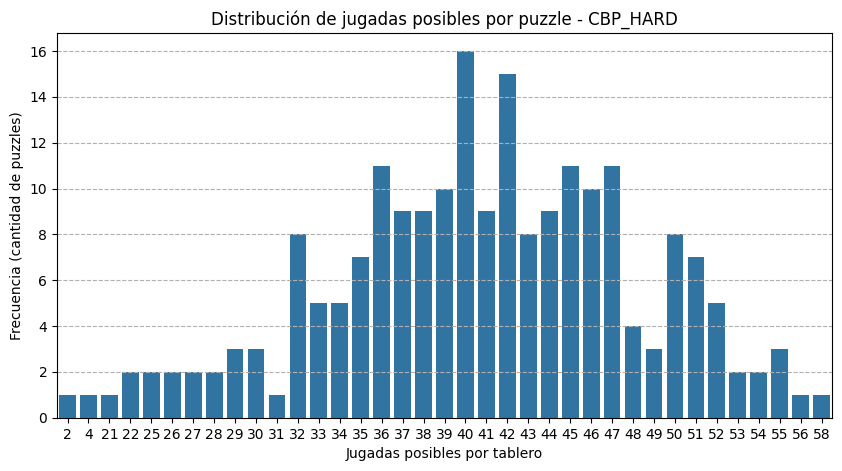

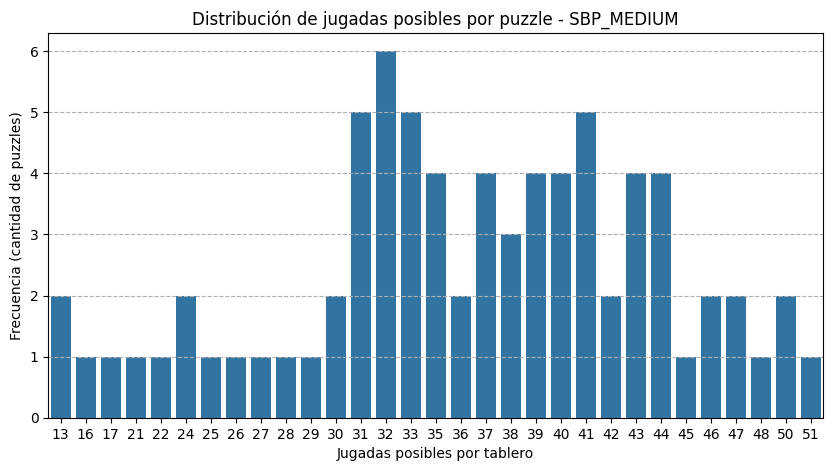

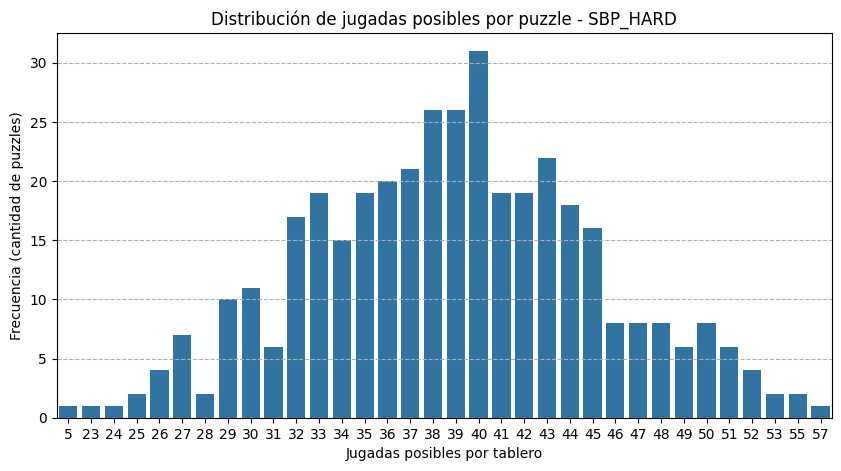

In [23]:
# Histograma de número de jugadas posibles por puzzle dado un dataset. No almacenado en Moves, que es la solución, sino
# dado el tablero, el total de posibles jugadas

for name,df in dfs.items():
    df['jugadasPosibles'] = df['FEN'].apply(lambda fen: len(list(chess.Board(fen).legal_moves)))

    plt.figure(figsize=(10,5))
    sns.countplot(data=df,x='jugadasPosibles', order=sorted(df['jugadasPosibles'].value_counts().index))
    plt.title(f'Distribución de jugadas posibles por puzzle - {name}')
    plt.xlabel('Jugadas posibles por tablero')
    plt.ylabel('Frecuencia (cantidad de puzzles)')
    plt.grid(axis='y', linestyle='--')
    plt.show()

Las conclusiones extraídas son las siguientes:

- La mayoría de tableros asociados a los puzzles de táctica difícil tienen entre 35 y 50 jugadas posibles, con un pico en torno a las 40 jugadas. Esto indica posiciones de las que se puede extraer mucha actividad, donde hay muchas amenazas y, a su vez, muchas respuestas a ellas. Esto obligaría a hacer jugadas concretas de entre las muchas disponibles.

- En los de estrategia de nivel medio se observa más dispersión, pero con una concentración entre las 30 y 45 posibles jugadas, sugiriendo escenarios estratégicos de dificultad no demasiado elevada, donde se requiere la evaluación de distintas alternativas (sin que una pueda considerarse la mejor).

- La distribución de posibles jugadas legales por puzzle en los de estrategia difícil presenta más simetría que el resto, centrada en torno a las 39 y 41 jugadas posibles, con muchos tableros teniendo más de 40 posibles jugadas. Esta disposición de muchas posibilidades es común en contextos complejos de estrategia, donde sí se podría hablar de ”mejor jugada”, pero entre muchas que no son tan malas a medio plazo.

## Mapas de calor

Sería buena idea un mapa de calor por dataset, donde una matriz es el tablero e indica las veces que una casilla (elemento de la matriz) es ocupado

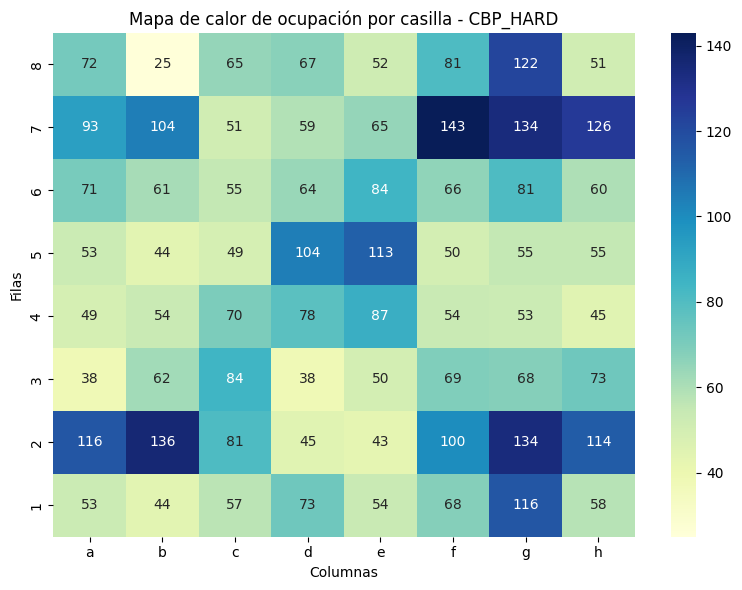

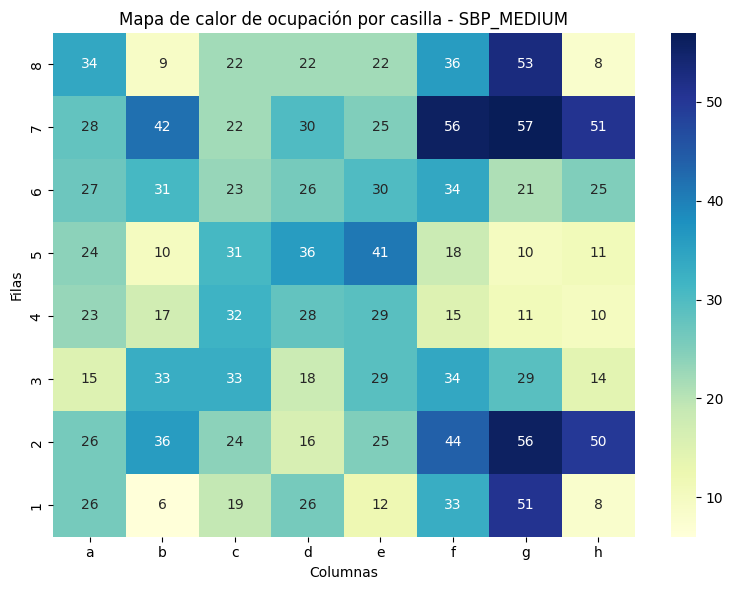

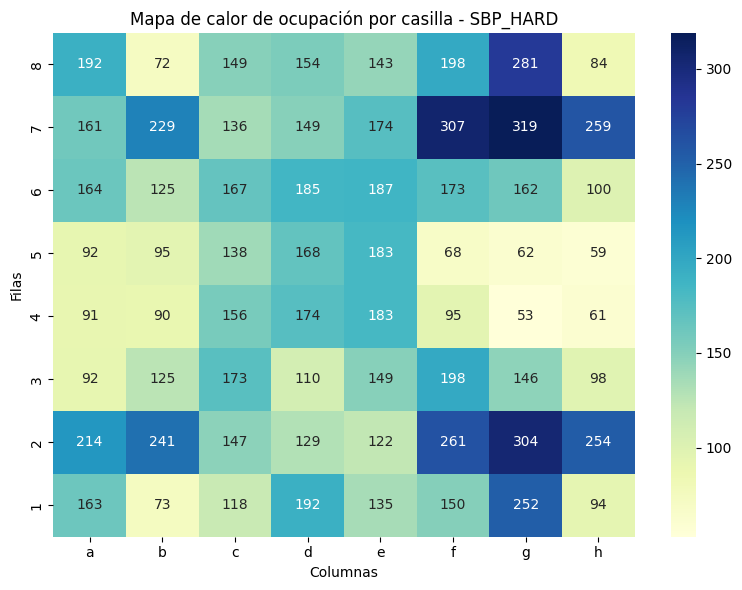

In [33]:
archivos = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
filas = list(range(8, 0, -1))  # De 8 a 1, fila 0 es la octava

for name, df in dfs.items():
    matrix = np.zeros((8, 8), dtype=int)   # Inicializamos la matriz tablero
    
    for fen in df['FEN']:
        board = chess.Board(fen)
        for square in chess.SQUARES:
            if board.piece_at(square):
                fila = 7 - chess.square_rank(square)  # fila 0 = octava fila (invertido)
                col = chess.square_file(square)
                matrix[fila][col] += 1
    
    # Mostrar mapa de calor
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap="YlGnBu", 
                xticklabels=archivos, yticklabels=filas, cbar=True)
    plt.title(f'Mapa de calor de ocupación por casilla - {name}')
    plt.xlabel('Columnas')
    plt.ylabel('Filas')
    plt.tight_layout()
    plt.show()

Lo anterior son mapas de calor GENERALES. Es decir, no distingue entre piezas. Ahora se conseguirán otros POR PIEZA. Es decir, para el peón (P) se consigue sus mapas de calor por dataset, para el rey (K) igual,... Con el objetivo de así poder ver si las casillas ocupadas son para soluciones de enroque,...

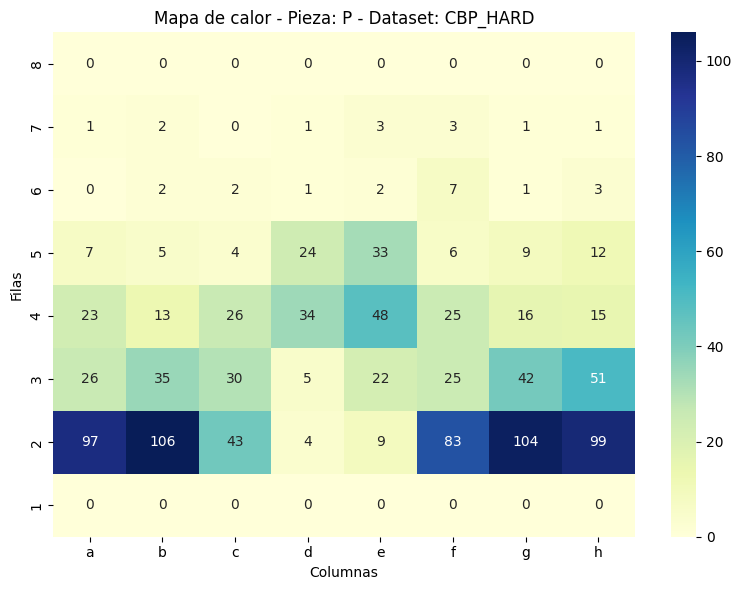

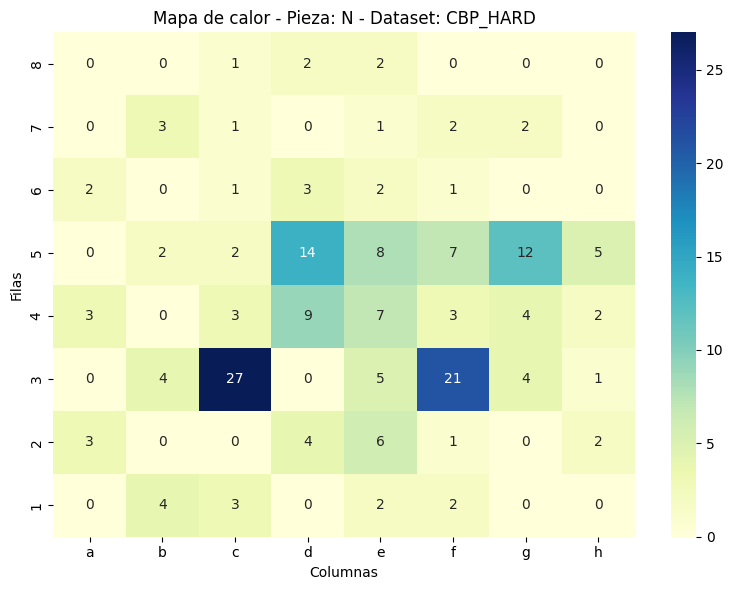

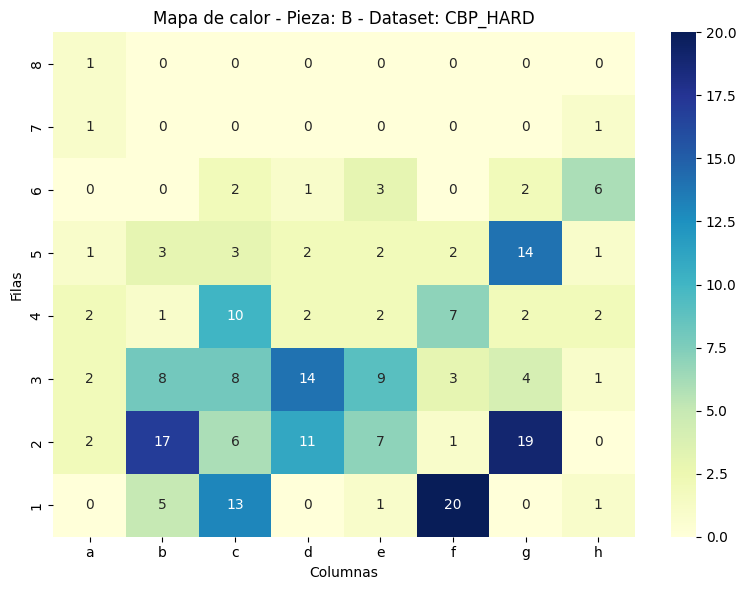

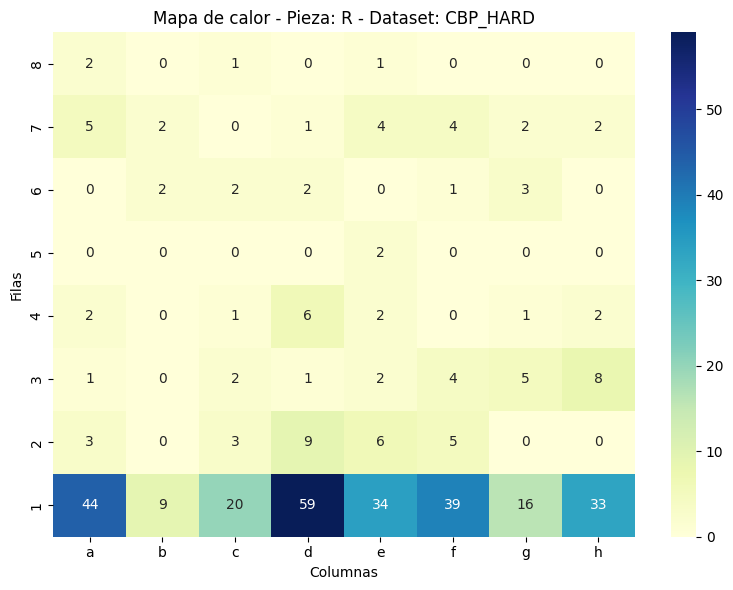

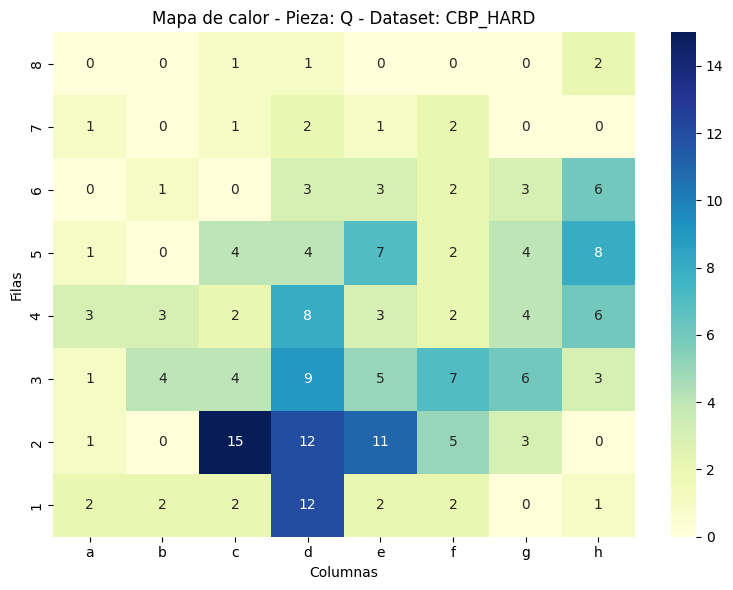

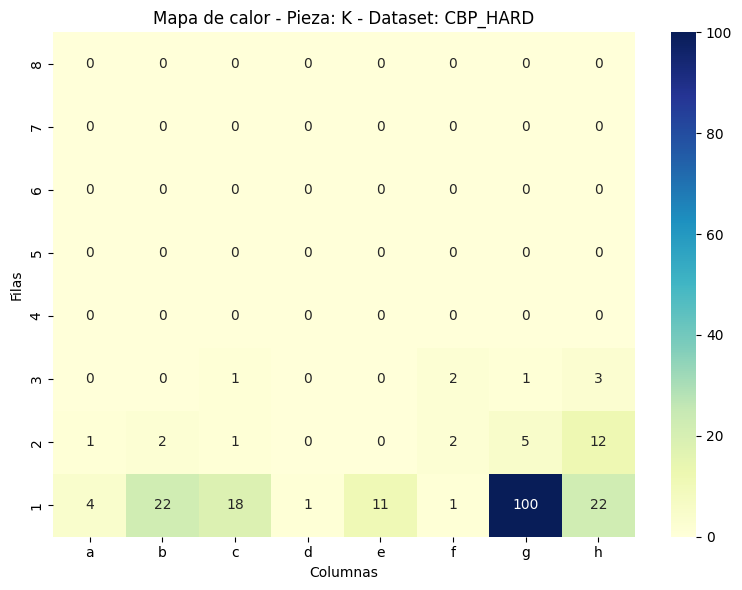

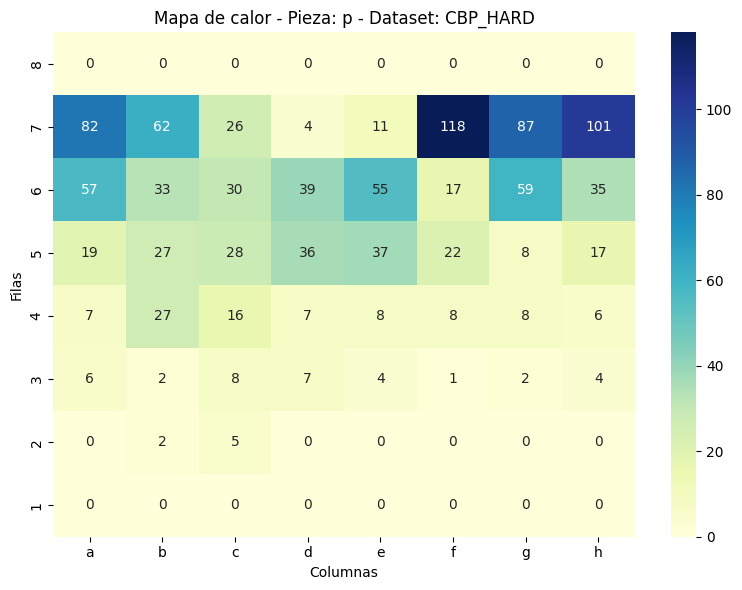

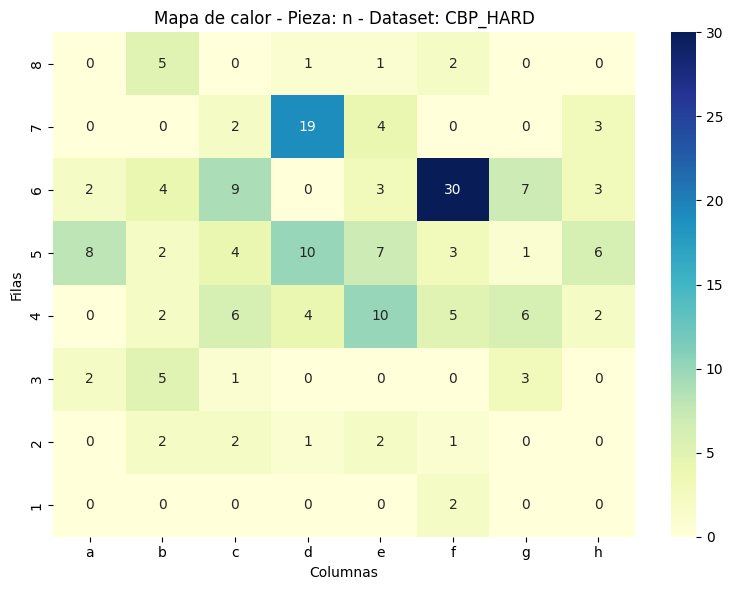

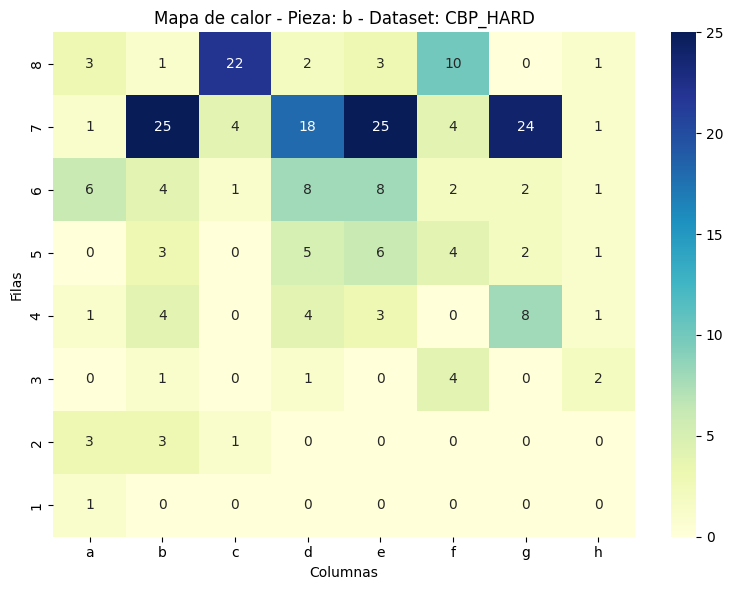

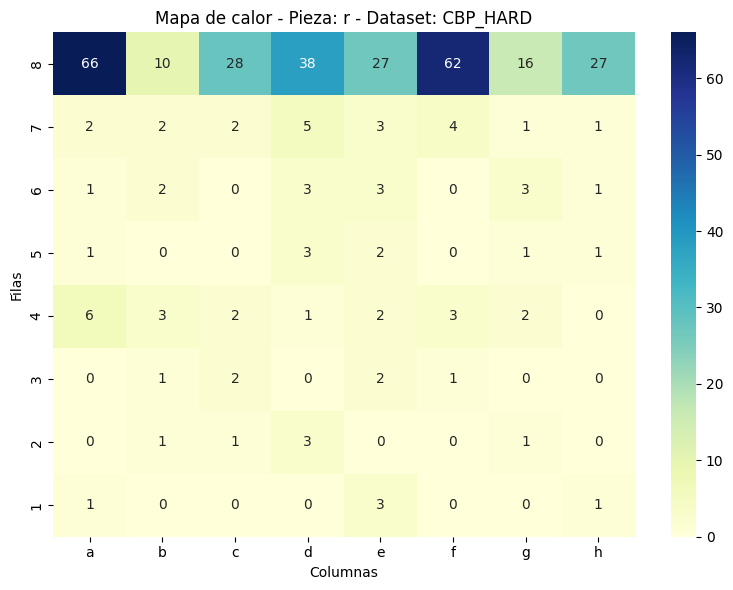

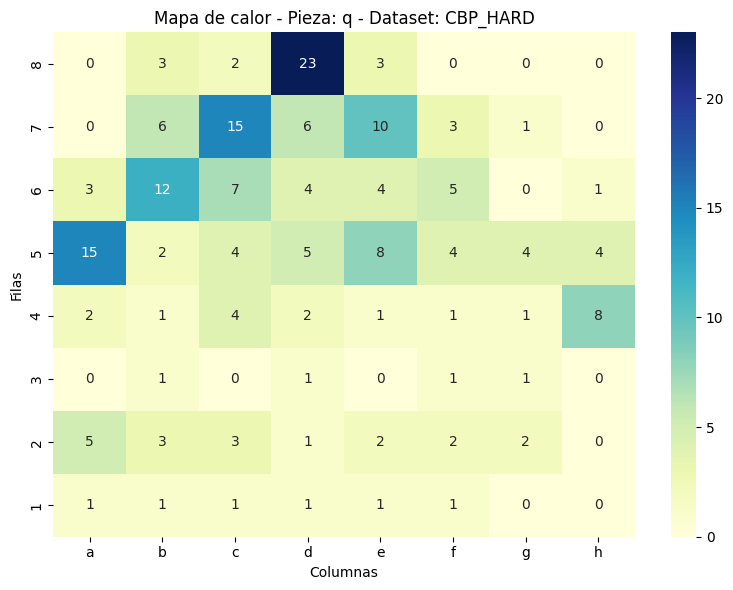

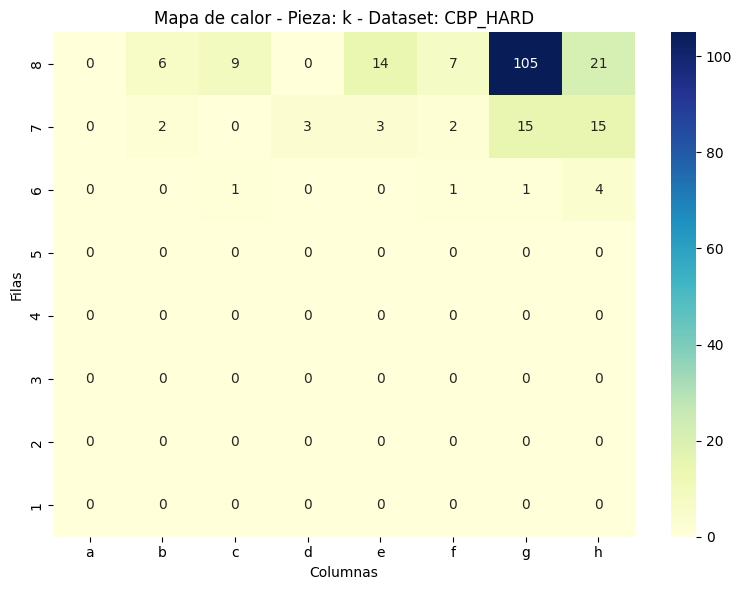

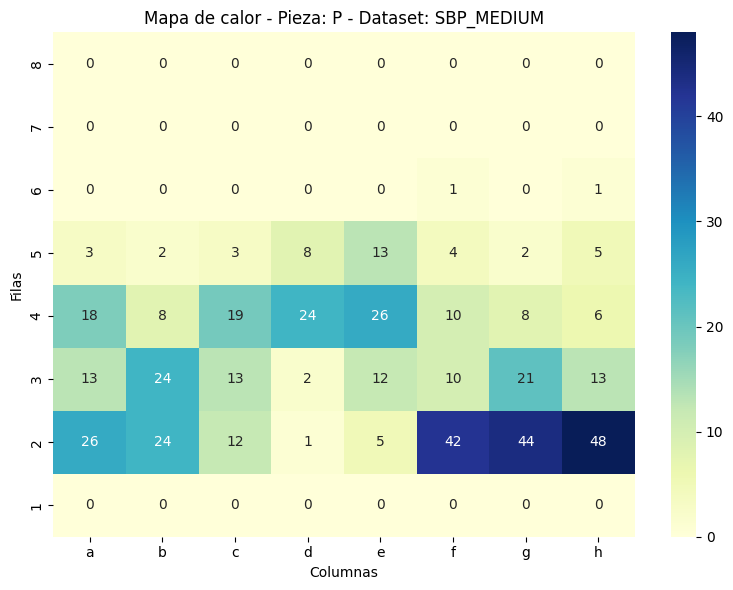

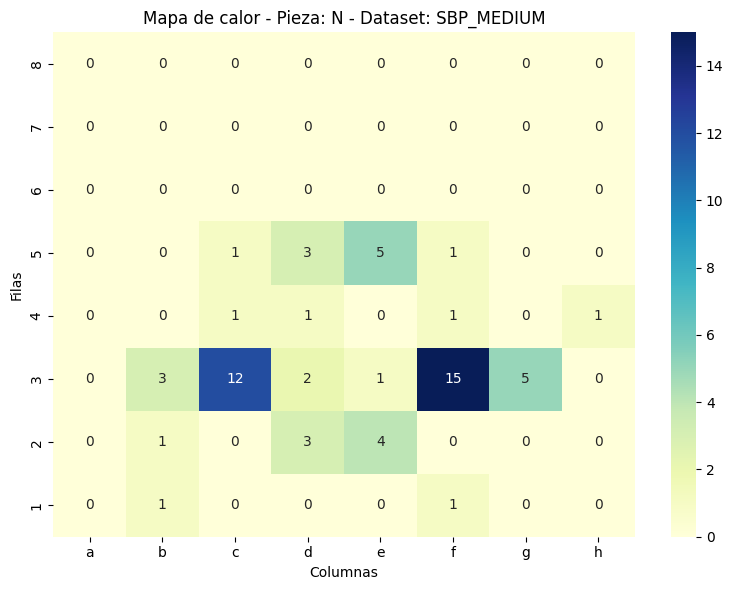

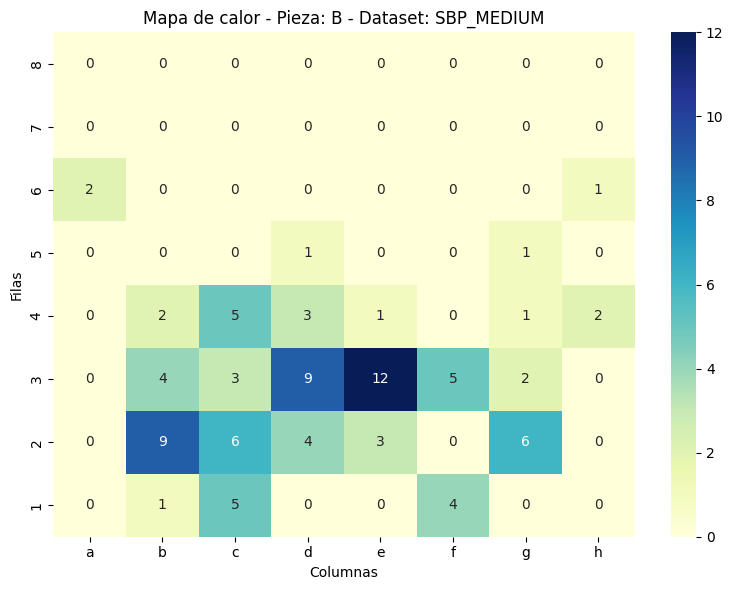

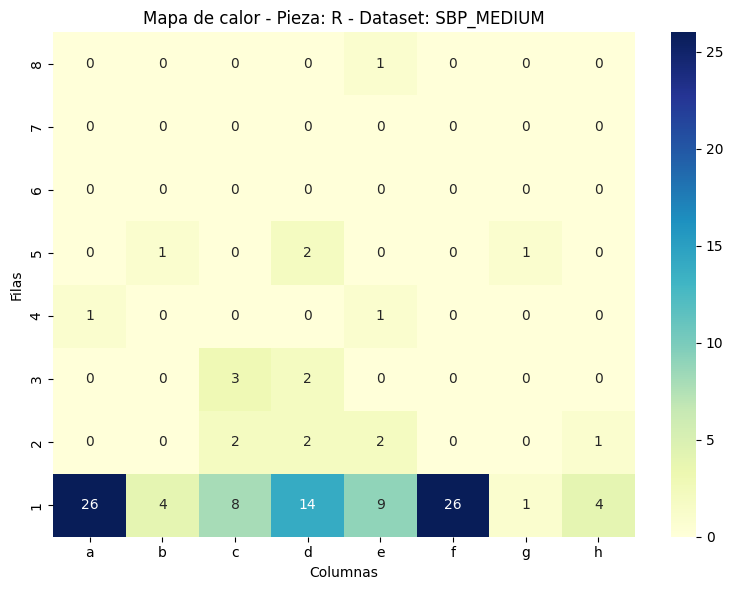

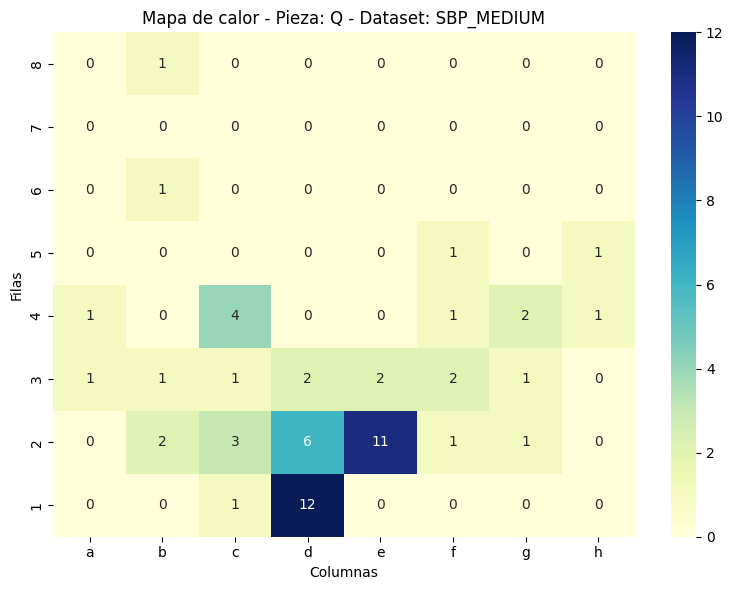

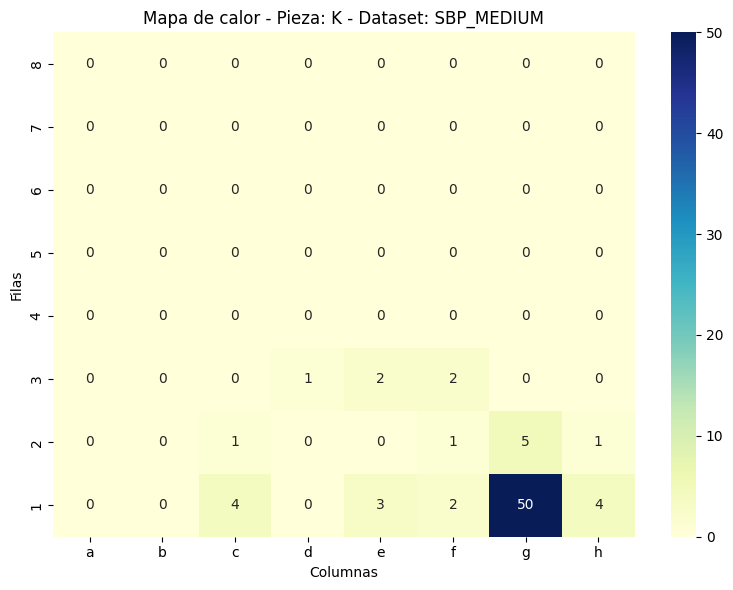

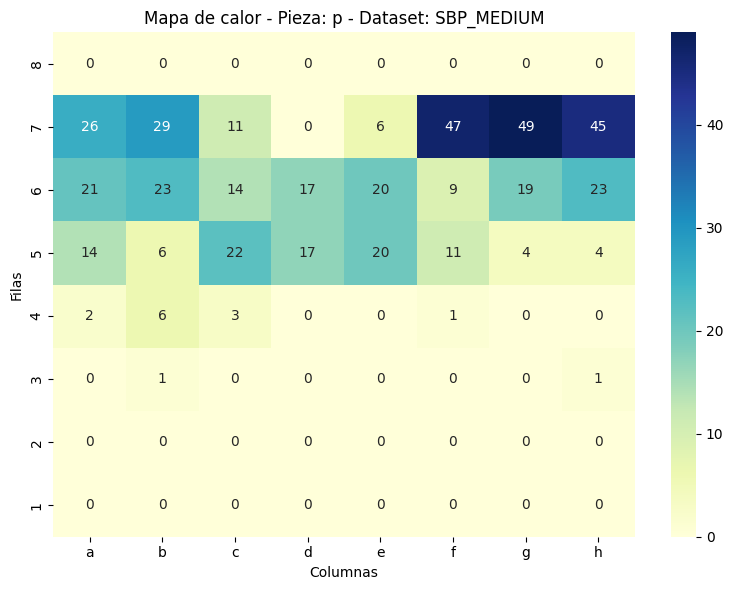

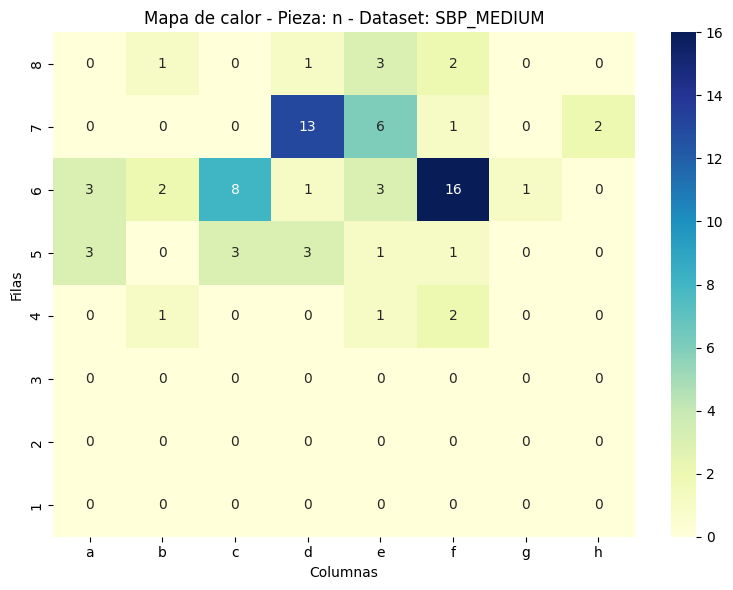

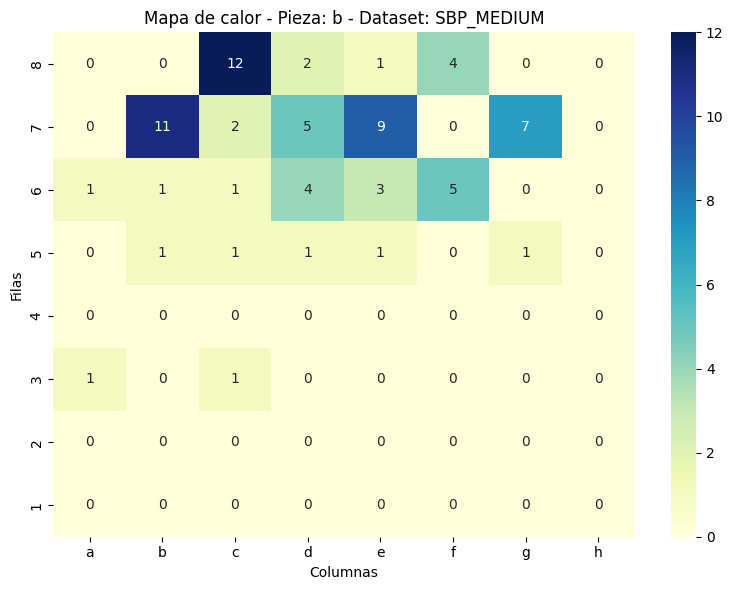

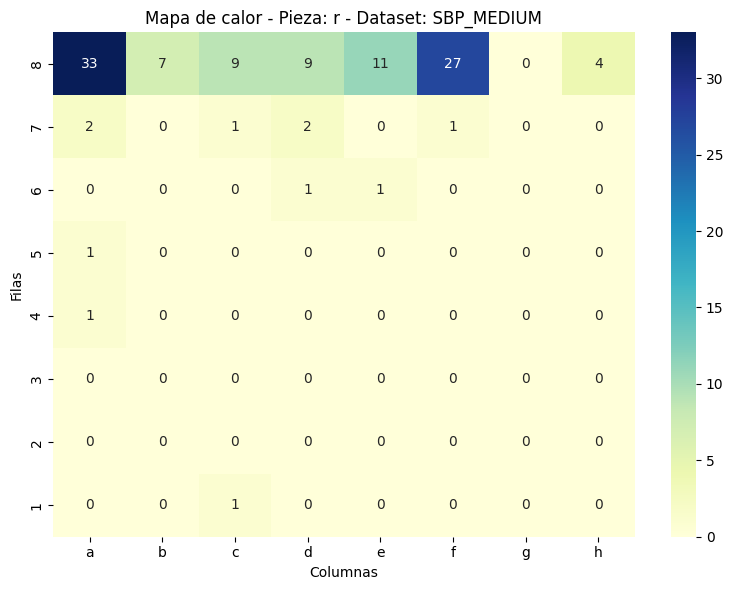

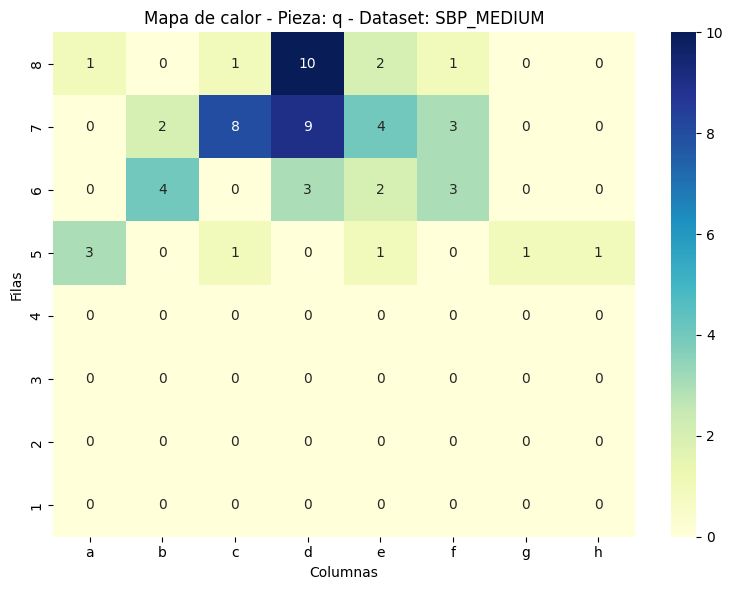

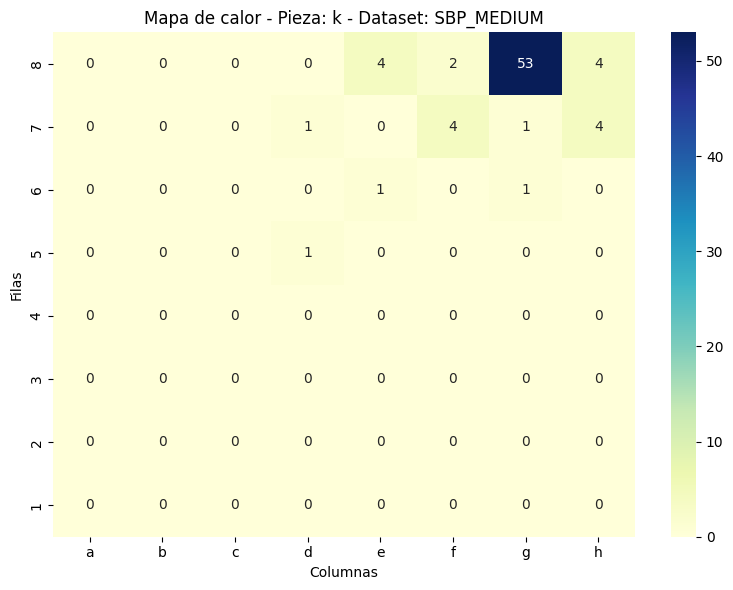

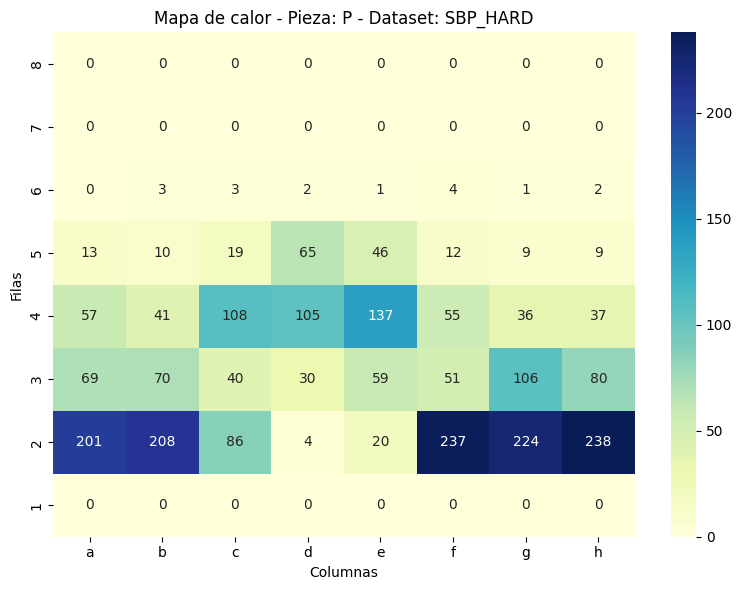

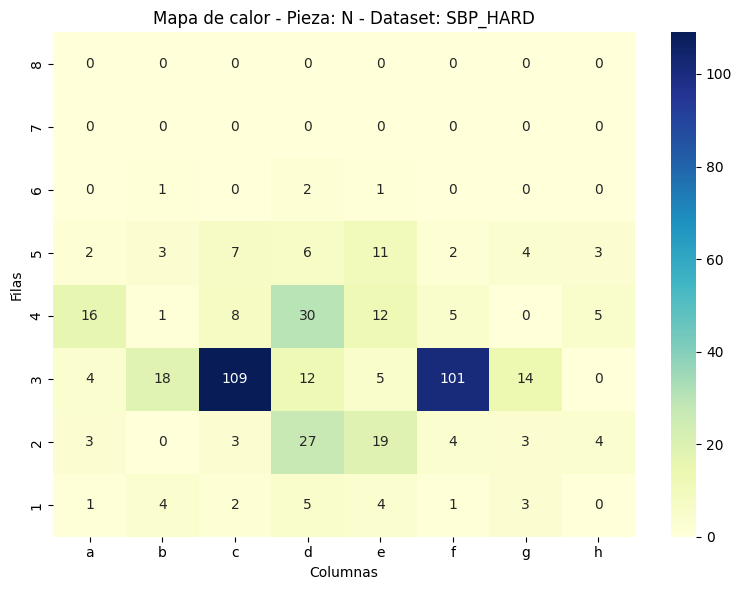

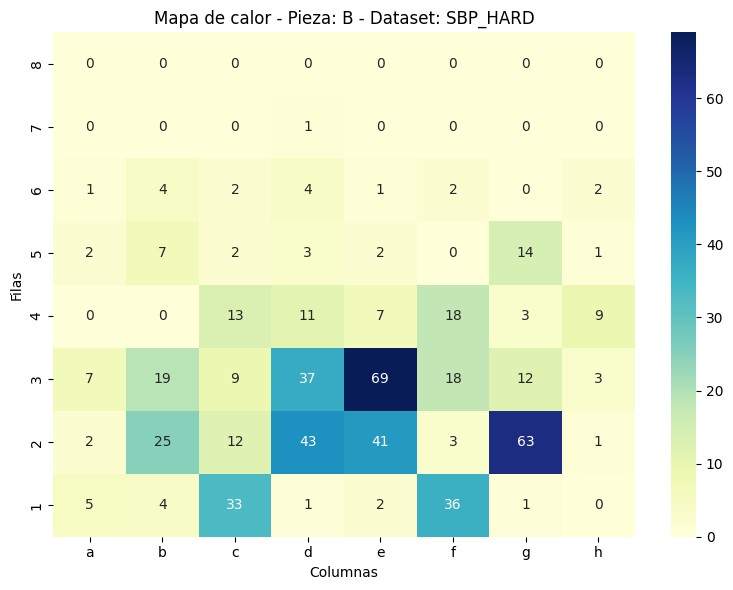

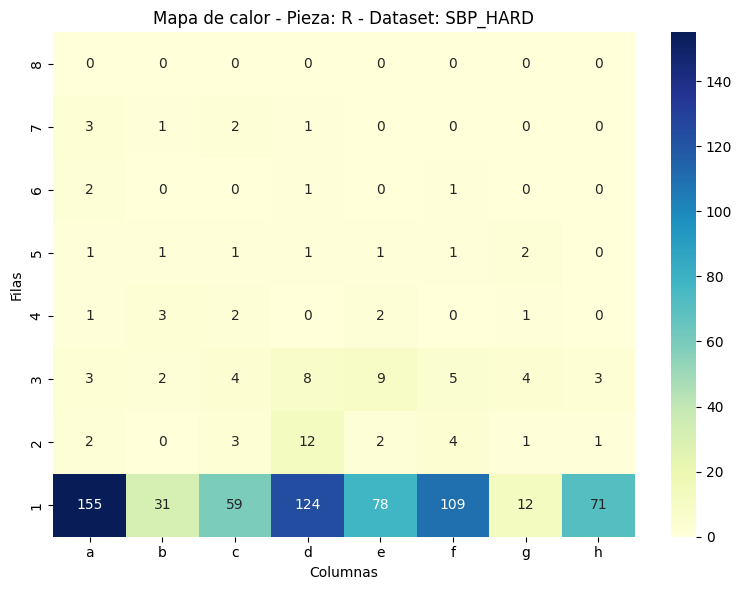

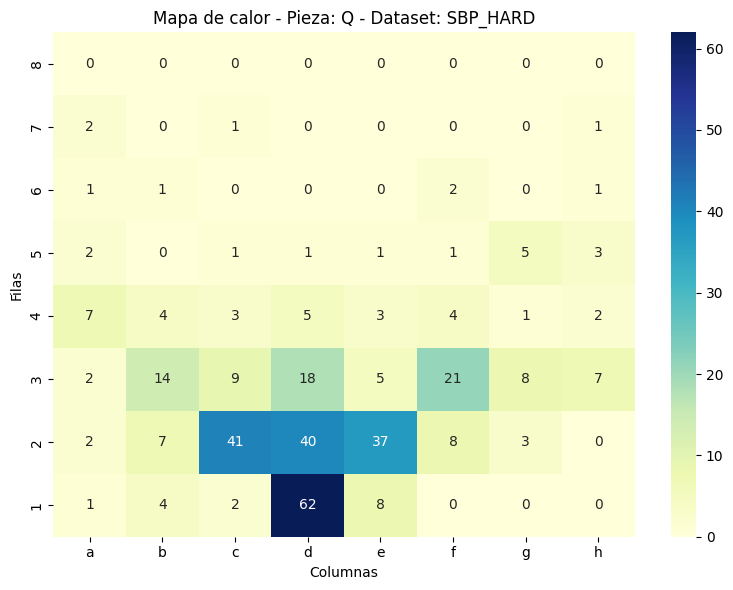

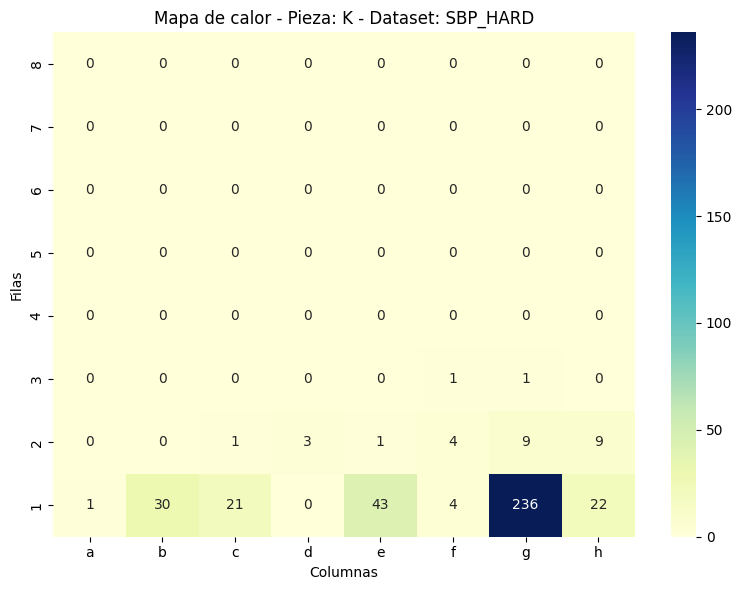

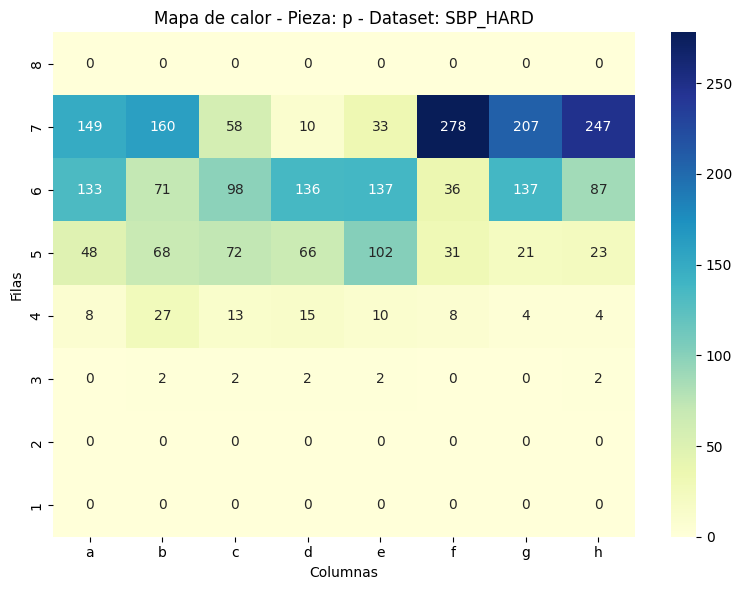

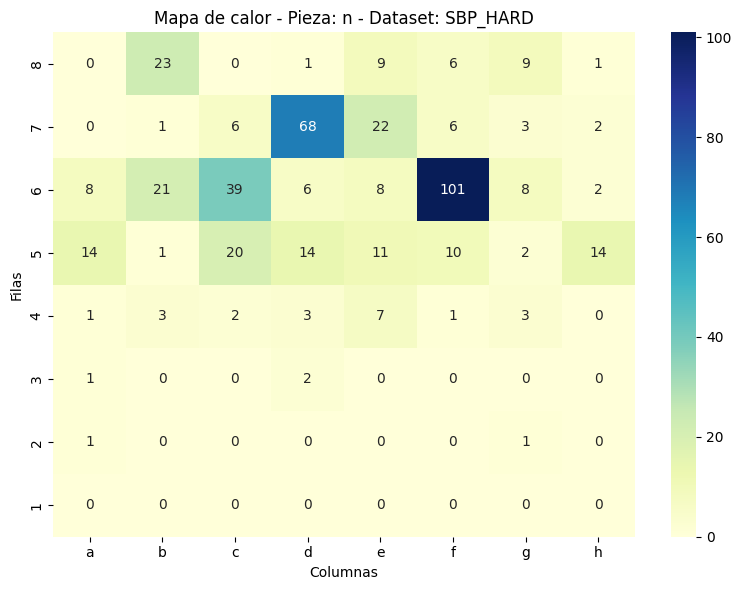

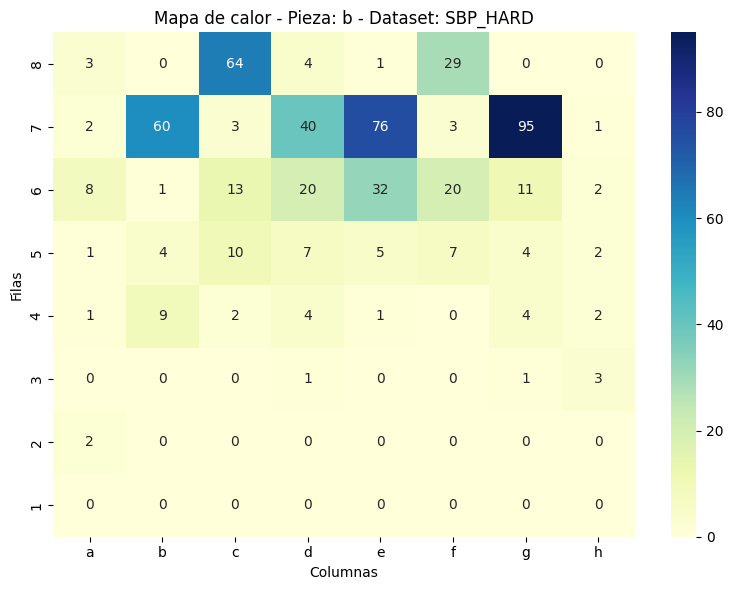

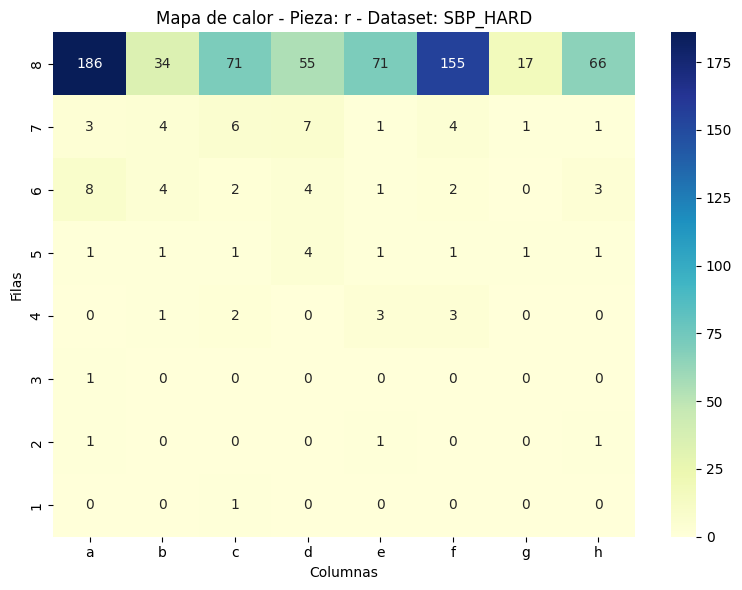

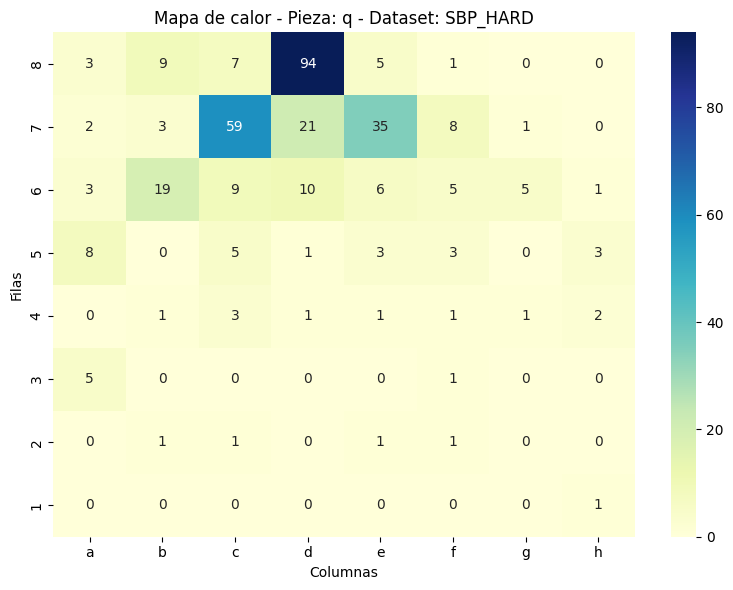

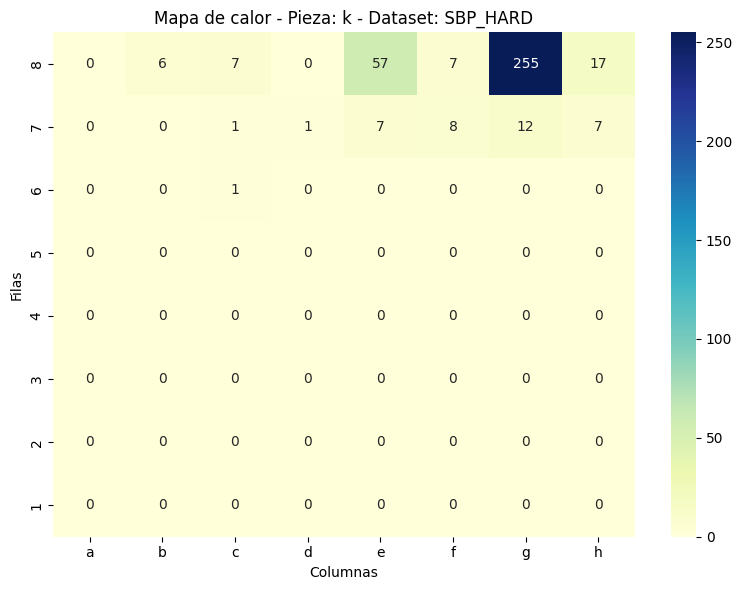

In [27]:
archivos = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
filas = list(range(8, 0, -1))  # De 8 a 1, fila 0 es la octava
fichas = ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']

for name, df in dfs.items():
    for ficha in fichas:
        matrix = np.zeros((8, 8), dtype=int)  # Mapa de calor para la ficha actual
        for fen in df['FEN']:
            board = chess.Board(fen)
            for square in chess.SQUARES:
                piece = board.piece_at(square)
                if piece and piece.symbol() == ficha:
                    fila = 7 - chess.square_rank(square)  # fila 0 = octava fila
                    col = chess.square_file(square)
                    matrix[fila][col] += 1

        # Mostrar mapa de calor para la ficha actual
        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix, annot=True, fmt='d', cmap="YlGnBu",
                    xticklabels=archivos, yticklabels=filas, cbar=True)
        plt.title(f'Mapa de calor - Pieza: {ficha} - Dataset: {name}')
        plt.xlabel('Columnas')
        plt.ylabel('Filas')
        plt.tight_layout()
        plt.show()

Aunque se desarrolla por extenso en la memoria, las premisas que se pueden extraer finalmente de los mapas del calor son las siguientes:

- Ocupación del tablero: SBP HARD muestra una densidad alta de piezas, especialmente en las filas 2y 7, y en el flanco del rey, lo que indica posiciones estratégicas complejas. CBP HARD presenta posiciones algo más despejadas, con concentración en casillas críticas para decisiones tácticas. SBP MEDIUM está en un punto intermedio entre los dos conjuntos anteriores: tiene una densidad de piezas algo menor que SBP HARD pero algo mayor que CBP HARD.

- Distribución del tablero: En CBP HARD las soluciones pueden involucrar piezas en posición de ataque y defensa. En los puzzles de estrategia (sobre todo en SBP HARD), los peones parecen ser la pieza clave dada su distribución más dispersa.

- Posición de las piezas: En los puzzles de estrategia las piezas suelen estar en posiciones relativamente más conservadoras que en los de táctica (véase torres en retaguardia o reyes enrocados).

## Conteo de piezas por dataset

Contar cuántas hay de cada tipo por dataset: si en los fáciles dan más piezas a usar de un tipo que de otro que en los difíciles, ídem táctica vs estrategia. Si dan más o menos piezas a usar en estrategia que en táctica,....

In [25]:
# Primero ponemos todas las piezas posibles según FEN
PIEZAS = ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']

resumen = pd.DataFrame(
    columns=['Dataset']+PIEZAS
)

for name,df in dfs.items():
    contador_total = Counter()

    for fen in df['FEN']:
        board=fen.split()[0]

        contador = Counter(c for c in board if c.isalpha())
        contador_total+=contador

    fila = [name]+[contador_total[pieza] for pieza in PIEZAS]
    resumen.loc[len(resumen)] = fila

print(tabulate(resumen, headers='keys', tablefmt='fancy_grid'))

╒════╤════════════╤══════╤═════╤═════╤═════╤═════╤═════╤══════╤═════╤═════╤═════╤═════╤═════╕
│    │ Dataset    │    P │   N │   B │   R │   Q │   K │    p │   n │   b │   r │   q │   k │
╞════╪════════════╪══════╪═════╪═════╪═════╪═════╪═════╪══════╪═════╪═════╪═════╪═════╪═════╡
│  0 │ CBP_HARD   │ 1111 │ 193 │ 225 │ 353 │ 199 │ 209 │ 1138 │ 192 │ 234 │ 351 │ 202 │ 209 │
├────┼────────────┼──────┼─────┼─────┼─────┼─────┼─────┼──────┼─────┼─────┼─────┼─────┼─────┤
│  1 │ SBP_MEDIUM │  471 │  62 │  92 │ 111 │  60 │  76 │  471 │  78 │  75 │ 111 │  60 │  76 │
├────┼────────────┼──────┼─────┼─────┼─────┼─────┼─────┼──────┼─────┼─────┼─────┼─────┼─────┤
│  2 │ SBP_HARD   │ 2498 │ 465 │ 555 │ 730 │ 351 │ 386 │ 2507 │ 461 │ 558 │ 731 │ 350 │ 386 │
╘════╧════════════╧══════╧═════╧═════╧═════╧═════╧═════╧══════╧═════╧═════╧═════╧═════╧═════╛


En primer lugar, y dado que en una partida siempre debe aparecer el rey en ambos colores, es conveniente resaltar que la cantidad de reyes es la misma que la de puzzles en cada conjunto. Por otro lado, se puede afirmar que hay cierta simetría en las cantidades entre los dos colores, con cantidades casi iguales en todos los conjuntos, confirmando que los tableros están equilibrados en número de piezas por color. Es interesante resaltar también que la pieza dominante es el peón, que es con diferencia la más numerosa tanto en blancas como negras. Esto es natural, dada la importancia de estos tanto en situaciones tácticas como estratégicas.


Haciendo una separación entre problemas de táctica y de estrategia, CBP HARD tiene una menor cantidad de piezas total respecto a SBP HARD, ya que son problemas algo más simplificados (recuérdese que la solución es única en puzzles de táctica). SBP HARD destaca por ser el que más cantidad de piezas tiene, también debido a que es el conjunto con más puzzles. Finalmente, SBP MEDIUM es el que menos piezas presenta, más allá de que es el que menos puzzles tiene, por tener puzzles algo más simples que los de estrategia difícil.

## Hipótesis: A los modelos les costarán más los problemas de táctica que de estrategia

# Evaluación dificultad problemas según Stockfish

Dos variantes de Stockfish:

- Stockfish con límite de tiempo a 0.05 segundos.

- Stockfish con profundidad 20.

La idea es sacar las columnas de probabilidad de victoria del movimiento de Stockfish según Stockfish en los dos casos y analizarlo.

In [10]:
dfs_probs_St = {}

for name, df in dfs_Stockfish.items():
    expected_cols = ['correct_Stockfish', '%win_Stockfish_best_move']

    missing_cols = [col for col in expected_cols if col not in df.columns]
    
    if missing_cols:
        print(f"[WARNING] {name}: faltan columnas {missing_cols}. Saltando.")
        continue

    # Guardamos solo las columnas relevantes
    dfs_probs_St[name] = df[expected_cols].copy()

    print(f"[INFO] {name} procesado:")
    print(dfs_probs_St[name])


[INFO] CBP_HARD_Stockfish procesado:
     correct_Stockfish  %win_Stockfish_best_move
0                 True                  0.500000
1                 True                  0.592805
2                 True                  0.707588
3                False                  0.174533
4                 True                  0.572213
..                 ...                       ...
204               True                  0.828104
205               True                  0.592805
206               True                  0.500000
207               True                  0.859553
208               True                  0.621773

[209 rows x 2 columns]
[INFO] CBP_HARD_Stockfish_20 procesado:
     correct_Stockfish  %win_Stockfish_best_move
0                 True                  0.452279
1                 True                  0.556826
2                 True                  0.731358
3                False                  0.458671
4                 True                  0.572213
..               

## Cantidad de puzzles resueltos por dataset

In [13]:
# Se cuenta por CSV y modelo de Stockfish la cantidad total de puzzles resueltos y no resueltos
for name,df in dfs_probs_St.items():
    print(f"[INFO] {name} - Cantidad de puzzles resueltos: {df['correct_Stockfish'].sum()}")
    print(f"[INFO] {name} - Cantidad de puzzles no resueltos: {df['correct_Stockfish'].count() - df['correct_Stockfish'].sum()}")

[INFO] CBP_HARD_Stockfish - Cantidad de puzzles resueltos: 178
[INFO] CBP_HARD_Stockfish - Cantidad de puzzles no resueltos: 31
[INFO] CBP_HARD_Stockfish_20 - Cantidad de puzzles resueltos: 198
[INFO] CBP_HARD_Stockfish_20 - Cantidad de puzzles no resueltos: 11
[INFO] SBP_MEDIUM_Stockfish - Cantidad de puzzles resueltos: 57
[INFO] SBP_MEDIUM_Stockfish - Cantidad de puzzles no resueltos: 19
[INFO] SBP_MEDIUM_Stockfish_20 - Cantidad de puzzles resueltos: 62
[INFO] SBP_MEDIUM_Stockfish_20 - Cantidad de puzzles no resueltos: 14
[INFO] SBP_HARD_Stockfish - Cantidad de puzzles resueltos: 300
[INFO] SBP_HARD_Stockfish - Cantidad de puzzles no resueltos: 86
[INFO] SBP_HARD_Stockfish_20 - Cantidad de puzzles resueltos: 314
[INFO] SBP_HARD_Stockfish_20 - Cantidad de puzzles no resueltos: 72


A grandes rasgos podemos ver que el motor de Stockfish con profundidad 20 resuelve más puzzles que el de límite de tiempo a 50 ms. Esto es obvio dado que el primero permite una exploración más profunda. Sin embargo, si nos ceñimos exclusivamente a la dificultad de los problemas, parece que en general los puzzles de táctica no son muy difíciles para Stockfish, mientras que en los de táctica falla más. Esto se debe a la propia naturaleza del algoritmo, que realiza una búsqueda exhaustiva en árbol (se hipotetiza que el Transformer será mejor en estrategia por su arquitectura y, por ende, en lo que al propio razonamiento a largo plazo implica).

## Histograma de la probabilidad de ganar (si fuese partida) por dataset

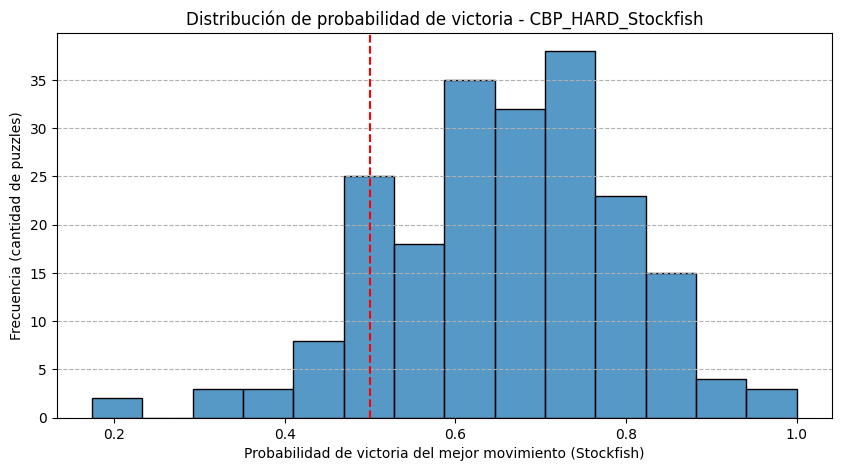

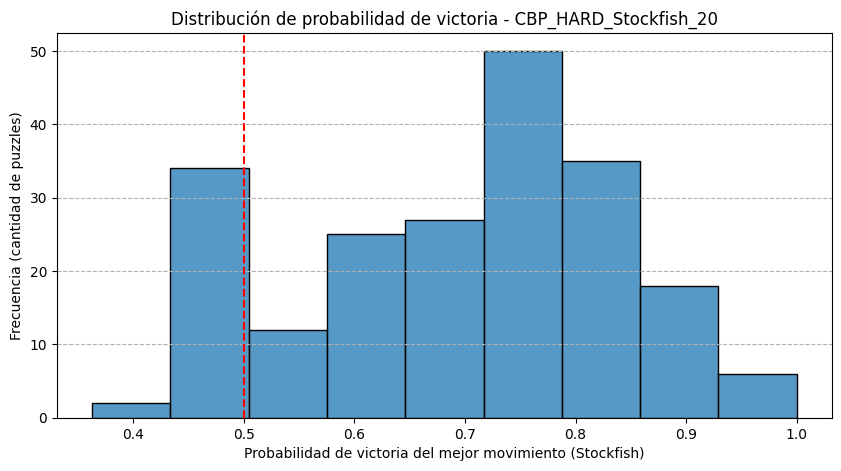

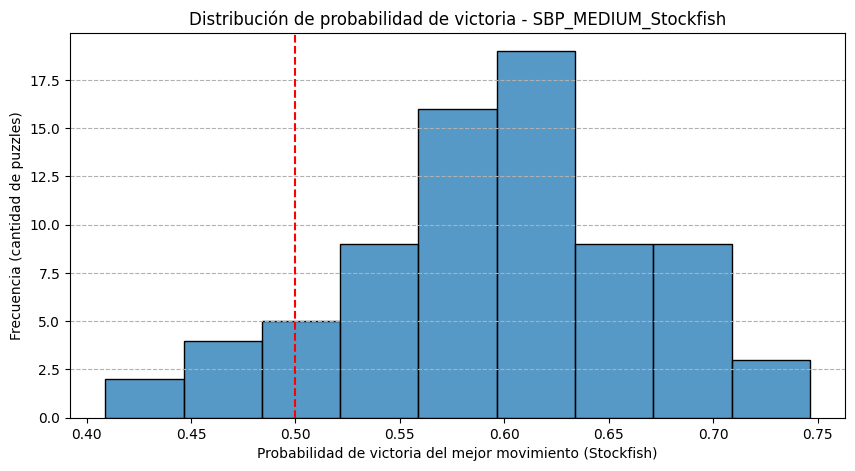

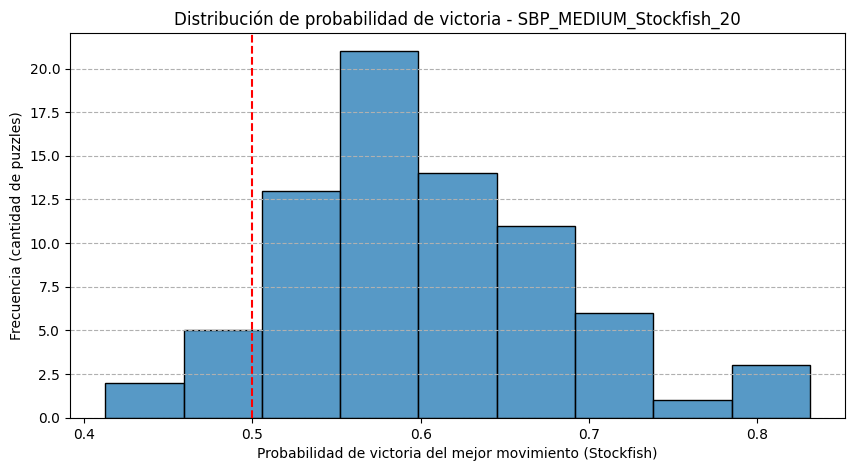

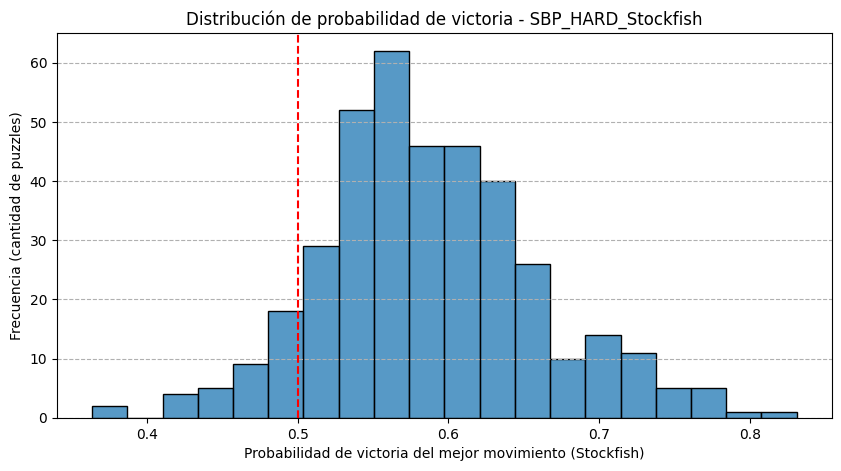

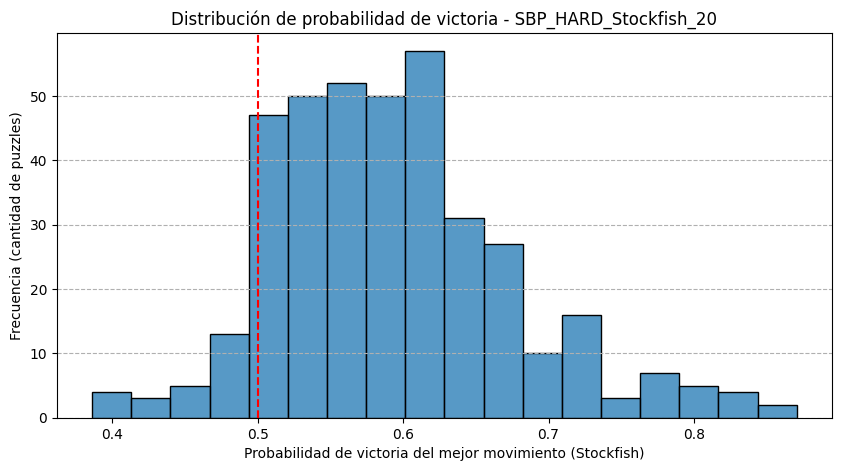

In [19]:
# Histograma de la probabilidad de ganar (si fuese partida) por dataset, dibujando línea roja en torno a 0.5

for name,df in dfs_probs_St.items():
    plt.figure(figsize=(10,5))
    sns.histplot(data=df, x='%win_Stockfish_best_move')
    # Dibuja línea roja en prob victoria=0.5
    plt.axvline(x=0.5, color='red', linestyle='--')
    plt.title(f'Distribución de probabilidad de victoria - {name}')
    plt.xlabel('Probabilidad de victoria del mejor movimiento (Stockfish)')
    plt.ylabel('Frecuencia (cantidad de puzzles)')
    plt.grid(axis='y', linestyle='--')
    plt.show()

- En los puzzles de táctica difícil se observa que a grandes rasgos la distribución de probabilidades de victoria se sitúa a la derecha de 0.5, concentrándose en una alta probabilidad de victoria. Por ende, aunque los puzzles se etiquetan como difíciles, se puede intuir que las soluciones son claras para un agente como Stockfish, incluso en tiempo limitado. Con esto vemos que la dificultad en estos puzzles se encuentra en elegir específicamente la solución de todos los movimientos posibles que, como ya vimos, son bastantes.

- En el conjunto SBP MEDIUM también podemos comprobar que la distribución se encuentra, en su mayoría, a la derecha de 0.5, aunque en menor medida que CBP HARD y con menor número de valores dispersos. Con esto vemos que la solución propuesta no necesariamente es la única, y existen varios movimientos razonables, aunque dando probabilidades algo menores cuando se limita el tiempo de pensamiento del agente.


- Finalmente, en SBP HARD  se observa una distribución más empatada, donde los mejores movimientos ofrecen ventajas no muy grandes (mayoría de probabilidades entre 0.5 y 0.6), sobre todo en el caso de Stockfish limitado a 50 ms. Además, la dispersión de valores muestra que incluso los movimientos solución no suelen dar ventajas significativas, lo que coincide con el etiquetado como difícil de los puzzles.

# Análisis bivariante

Boxplot de probabilidad de ganar según acierta o no Stockfish

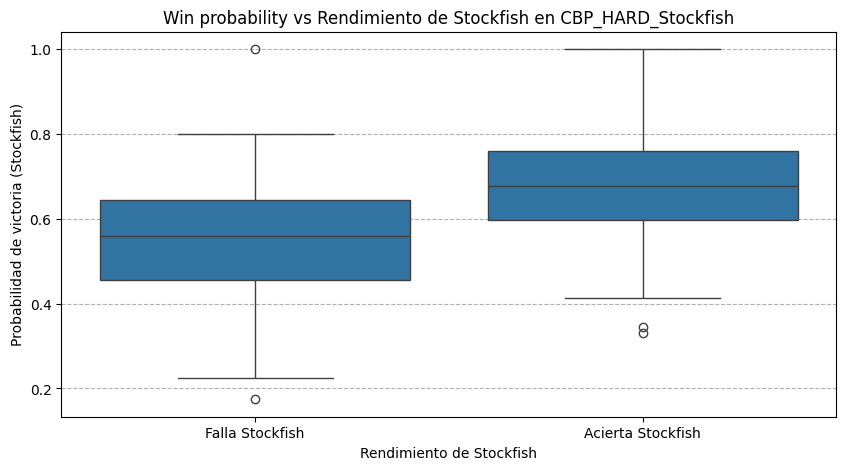

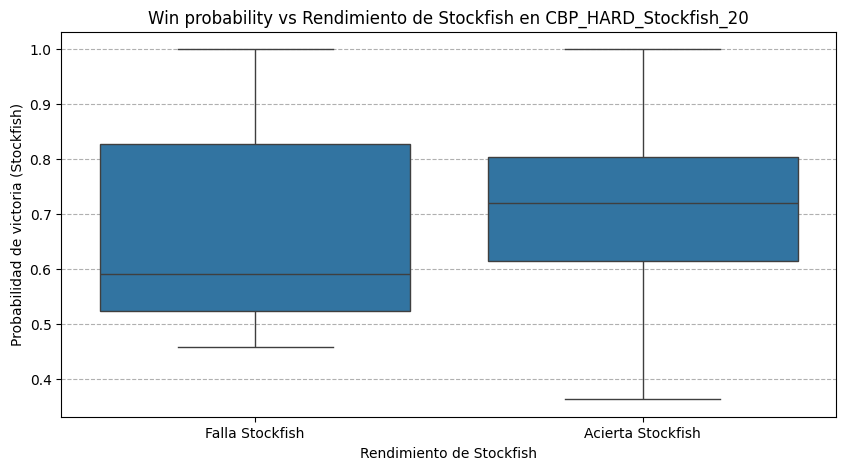

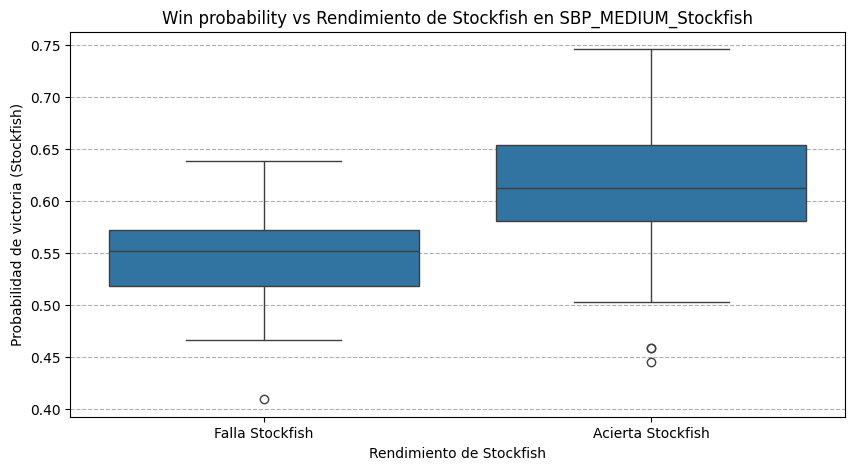

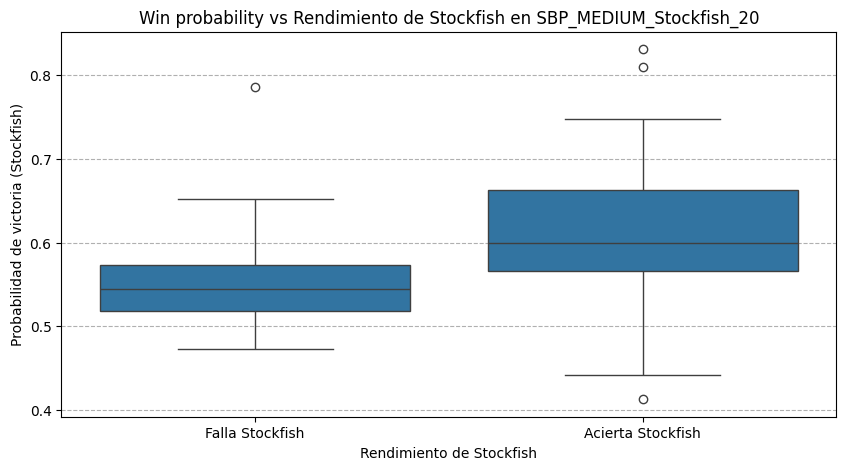

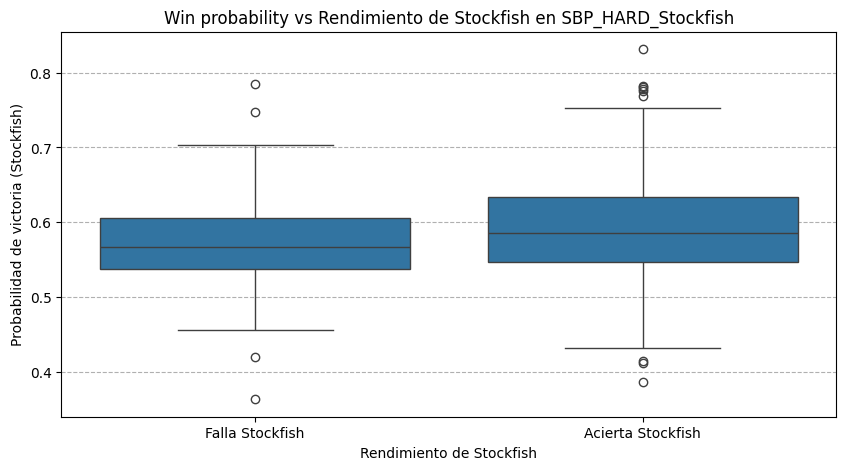

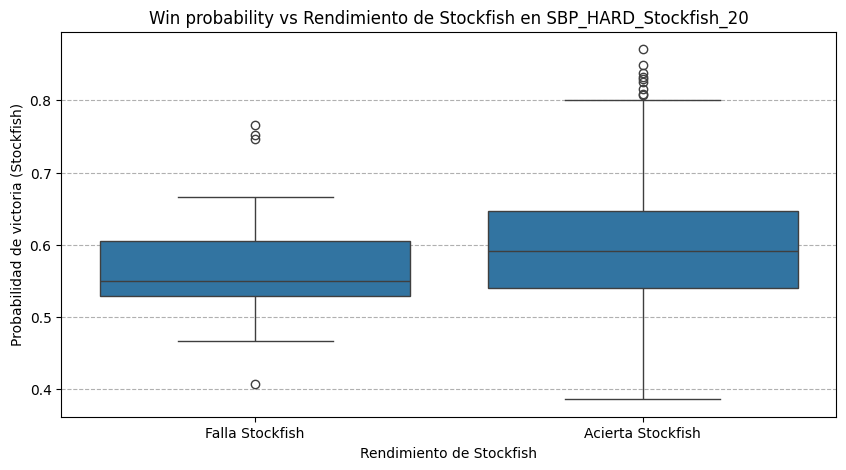

In [46]:
for name,df in dfs_probs_St.items():
    plt.figure(figsize=(10,5))
    sns.boxplot(x=(df['correct_Stockfish']), y=(df['%win_Stockfish_best_move']))
    plt.xticks([0,1],['Falla Stockfish','Acierta Stockfish'])
    plt.title(f'Win probability vs Rendimiento de Stockfish en {name}')
    plt.xlabel('Rendimiento de Stockfish')
    plt.ylabel('Probabilidad de victoria (Stockfish)')
    plt.grid(axis='y', linestyle='--')
    plt.show()

- CBP_HARD:  En estos boxplots puede observarse una diferencia clara entre fallos y aciertos, sobre todo en el agente con lÍmite de tiempo. Si el agente acierta la probabilidad de victoria es bastante alta, mientras que si falla son resultados bajos y/o en general dispersos. Con esto podemos observar que, ciertamente, Stockfish tiene alto rendimiento en problemas de táctica, pero cuando la situación inicial no es muy buena, o cercana al empate, es más probable que falle.

- SBP_MEDIUM: Aquí podemos observar una clara diferencia entre ambas distribuciones: si el agente acierta, la probabilidad de victoria en general es bastante más alta que si falla, salvo outliers y rango intercuartílico. También se puede comprobar que si se limita el tiempo de pensamiento en uno de los agentes, los outliers son a la baja, mientras que si se permite un análisis más profundo, son al alza. Sin embargo, ambas distribuciones de probabilidades presentan valores más cercanos al empate que en los puzzles de táctica.

- SBP_HARD: Al igual que en los puzzles de estrategia de nivel medio, los valores de la distribución son cercanos al empate, incluso más aún en la distribución de los aciertos. Por el contrario, podemos comprobar que en ambos agentes, ambas distribuciones poseen bastantes outliers, sobre todo al alza en la de acierto. De aquí podemos extraer que, aunque las jugadas correctas no dan mucha ventaja, hay casos en que el motor detecta movimientos da alto valor estratégico. La presencia de outliers y alta dispersión confirma la alta dificultad de los puzzles del conjunto.